In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
from scipy.stats import multivariate_normal

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('./data/train.csv')
data.head(10)

Id         0         1         2         3         4         5         6  \
0  120  0.147298 -0.142030  0.091737 -0.151707  0.060124  0.186191 -0.021298   
1  121  0.115710  0.105061  0.038446  0.166711 -0.113913  0.004528 -0.006954   
2  122 -0.548826 -0.466551 -0.650890 -0.553450 -0.449101 -0.496902 -0.464860   
3  123  0.192618  0.291155 -0.042980  0.146483  0.015390  0.019394 -0.005577   
4  124  0.075706  0.069045 -0.019818  0.068801 -0.226501  0.011658  0.087905   
5  125  1.081769  0.986722  1.067524  1.140523  0.975286  1.074729  0.871820   
6  126  0.212677  0.271821  0.052499  0.353935  0.177247  0.165208  0.077037   
7  127 -1.044003 -0.994305 -0.885585 -0.678902 -0.717464 -0.513387 -0.501884   
8  128  0.984083  0.938459  0.956299  0.922269  1.078399  1.107597  0.983515   
9  129 -0.056781  0.053274  0.033048  0.010449  0.101132 -0.055987 -0.045404   

          7         8  ...        91        92        93        94        95  \
0 -0.025636  0.061044  ... -0.218118  0.011316  0.079464 -0.010833 -0.053485   
1 -0.140054  0.154231  ...  0.021526  0.069009 -0.060343  0.094007  0.049558   
2 -0.394458 -0.271801  ...  0.057272  0.088062 -0.069730  0.168498  0.109672   
3 -0.048682  0.025772  ...  0.140831  0.257332  0.262786  0.351659  0.213291   
4 -0.080787 -0.080369  ...  0.434803  0.322841  0.297772  0.461421  0.406143   
5  1.140957  1.276274  ...  2.098946  1.882913  1.979897  1.852567  2.043995   
6  0.054077  0.001218  ...  0.880501  0.894316  0.776692  0.910526  1.145064   
7 -0.647595 -0.336069  ...  0.607999  0.508485  0.442513  0.644257  0.838618   
8  1.222726  1.049279  ...  1.937170  1.951902  2.069157  2.075734  1.953834   
9  0.012941 -0.047868  ...  0.231157  0.182868  0.240331  0.156288  0.218797   

         96        97        98        99  Category  
0  0.046450 -0.008333  0.168574  0.123273         0  
1  0.112370  0.020398  0.039687  0.217384         0  
2  0.202808 -0.019942  0.058902  0.053936         0  
3  0.251077  0.190920  0.251743  0.337730         1  
4  0.562082  0.554588  0.471489  0.384229         1  
5  2.059601  2.219500  2.038103  2.072409         1  
6  1.302965  1.182394  1.286594  1.184424         1  
7  0.936488  0.929766  0.965134  1.024578         1  
8  1.922141  1.913410  1.965790  1.956595         0  
9  0.042883  0.127180  0.130278  0.162561         0  

[10 rows x 102 columns]

# Test out on a single country

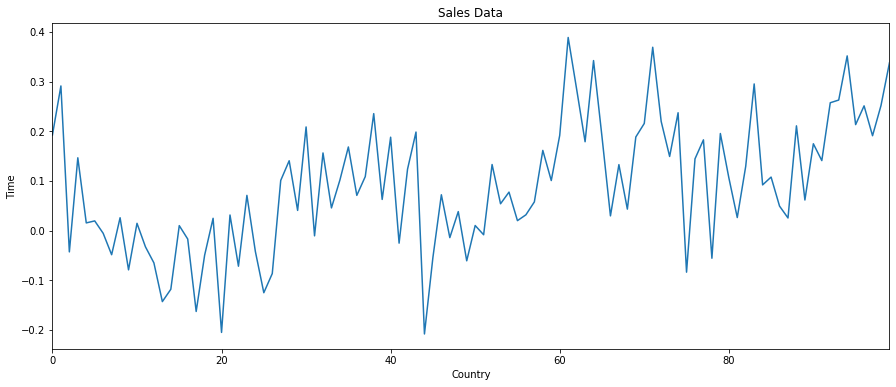

In [325]:
country_id = 3

ax = data.iloc[country_id,1:101].plot(figsize = (15,6), title="Sales Data", legend = False)
ax.set(xlabel="Country", ylabel="Time")
plt.show()

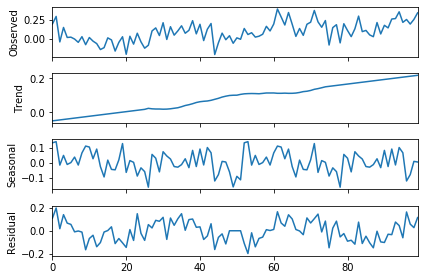

In [357]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data.iloc[country_id,1:101].T, model='additive', freq=52, extrapolate_trend='freq')
result.plot()
plt.show()

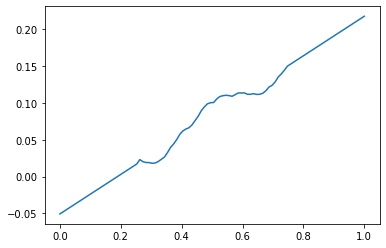

In [358]:
X = np.linspace(0,1,100)
Y = result.trend
X = X[:, None]
Y = Y[:, None]
plt.plot(X,Y)

In [359]:
# Contender 1
ker1 = GPy.kern.PeriodicMatern32(1, period=4)
ker2 = GPy.kern.ExpQuad(1)
kernel = ker1+ker2

In [389]:
def run_kernel():
    ker1 = GPy.kern.Linear(1)
    ker2 = GPy.kern.ExpQuad(1, variance=.5, lengthscale=40) #10 got 72
    kernel = ker1+ker2
    return kernel

Optimization restart 1/10, f = -334.2448430634264
Optimization restart 2/10, f = -477.3262253525969
Optimization restart 3/10, f = -334.24644707972016
Optimization restart 4/10, f = -473.45908399313754
Optimization restart 5/10, f = -477.32622534626614
Optimization restart 6/10, f = -477.32622535257474
Optimization restart 7/10, f = -477.3262253524177
Optimization restart 8/10, f = -334.24569445906536
Optimization restart 9/10, f = -477.3262245985927
Optimization restart 10/10, f = -334.24644328419225


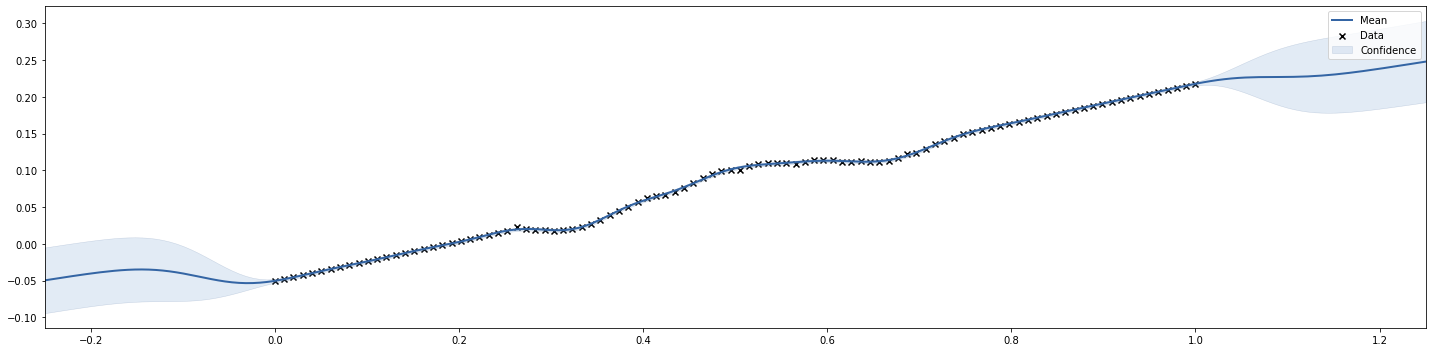

In [390]:
import GPy as GPy

kernel = run_kernel()

# create a GP model
g_model = GPy.models.GPRegression(X,Y,kernel=kernel)

# it finds the optimal parameters of the RBF kernel by maxisiming the marginal likelihood 
g_model.optimize_restarts(10)# this maximise the marginal likelihood, with random restarts
#we  plot it
fig = g_model.plot(figsize=(20,5))
display(g_model)

Looks good?

# Lets try on the training set

In [391]:
def run_model(x_in, y_in):
    import GPy as GPy

    kernel = run_kernel()

    g_model = GPy.models.GPRegression(x_in,y_in,kernel=kernel)

    g_model.optimize_restarts(20, robust=True, verbose=False, parallel=True, num_processes=12)
    
    X_test = x_in
    X_test = X_test.reshape(-1,1)
    
    f_pred, sigm_pred = g_model.predict(X_test, kern=kernel)
        
    plt.title('Prediction Plot')
    plt.plot(x_in[:,0],f_pred)
    plt.show()
    
    kernel.plot()
    plt.show()
    
    f_pred,sigm_pred = g_model.predict_noiseless(X_test, full_cov=True)
    Z = np.random.multivariate_normal(f_pred.T[0],sigm_pred,1000).T
    
    posterior_probability_deriviative_is_positive = (np.diff(np.mean(Z.T,axis=0), 1)>0).sum()/len(np.mean(Z.T,axis=0))
    

    if posterior_probability_deriviative_is_positive>0.85:
        return 1
    else:
        return 0

In [392]:
# sd = seasonal_decompose(data.iloc[0:75,1:101], model='additive', freq=52, extrapolate_trend='freq')
# sd.plot()
# plt.show()

# non_seasonal = sd.trend

In [393]:
rows = data.shape[0] - 0
actual = data.head(rows)['Category']

print(rows)
print(actual.shape[0])

75
75


Iteration: 1 of 75


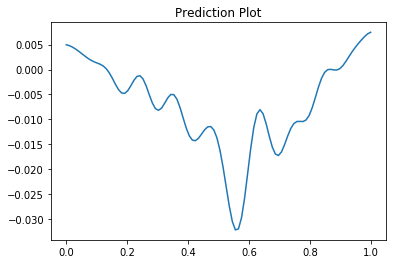

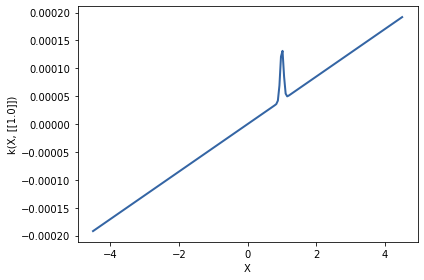

Iteration: 2 of 75


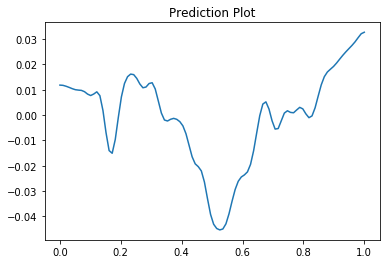

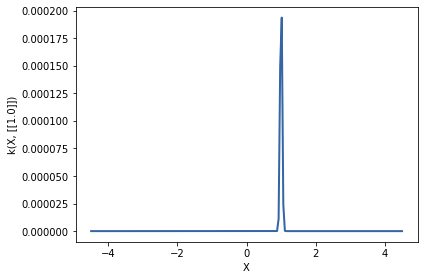

Iteration: 3 of 75


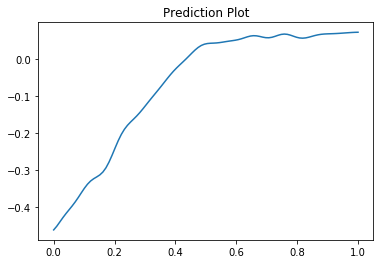

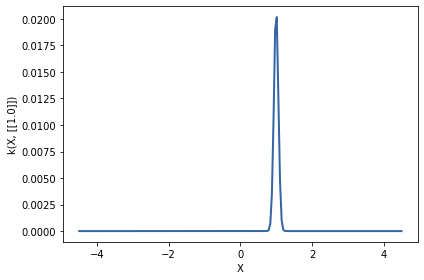

Iteration: 4 of 75


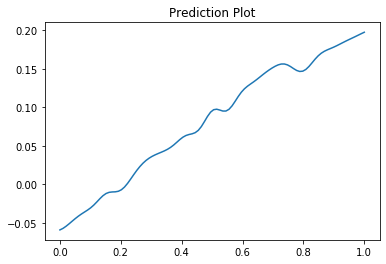

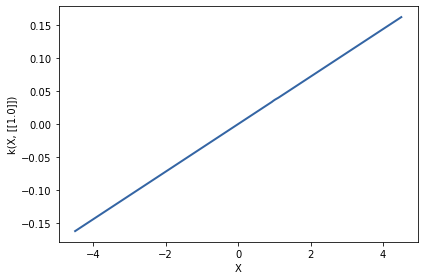

Iteration: 5 of 75


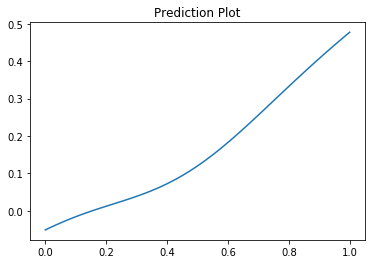

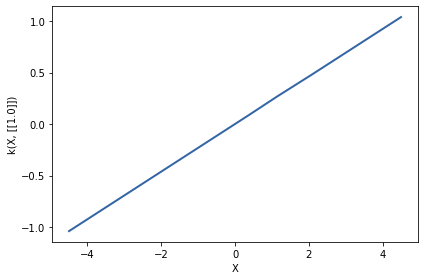

Iteration: 6 of 75


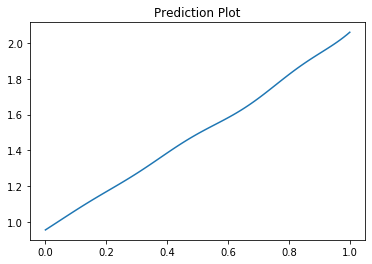

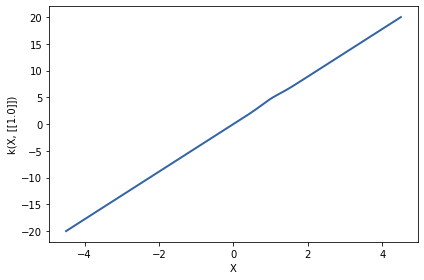

Iteration: 7 of 75


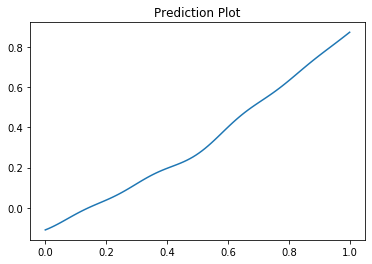

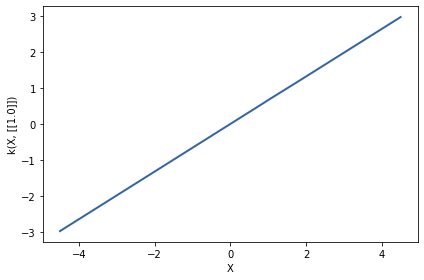

Iteration: 8 of 75


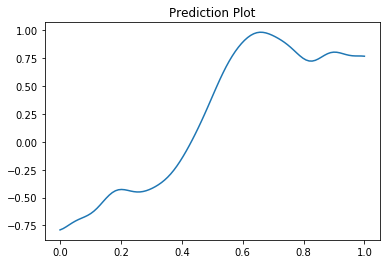

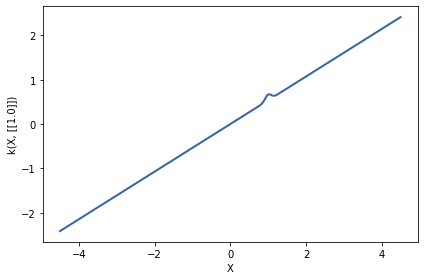

Iteration: 9 of 75


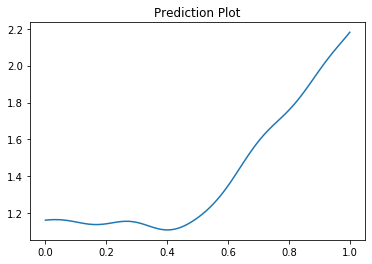

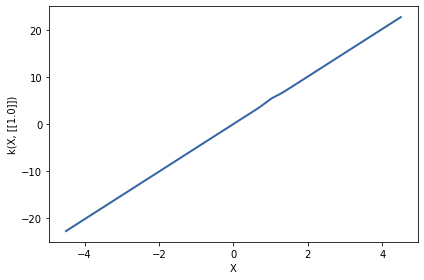

Iteration: 10 of 75


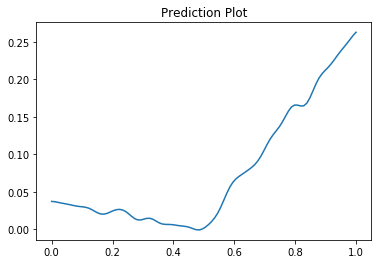

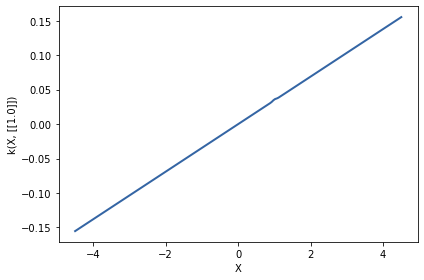

Iteration: 11 of 75


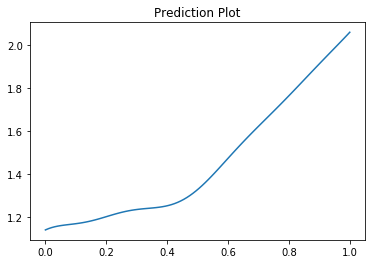

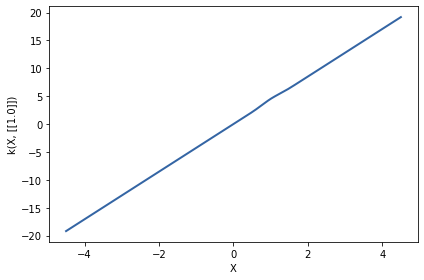

Iteration: 12 of 75


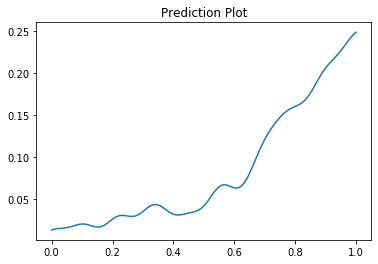

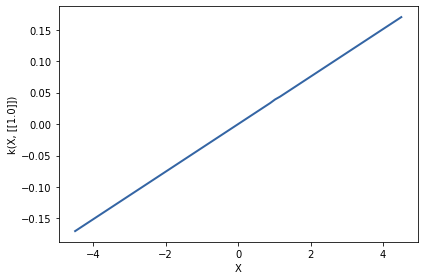

Iteration: 13 of 75


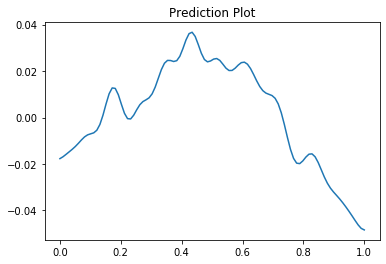

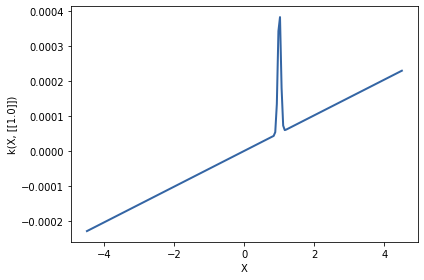

Iteration: 14 of 75


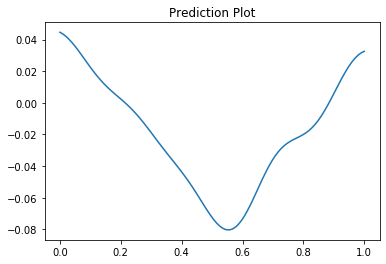

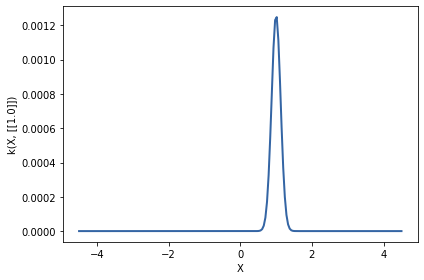

Iteration: 15 of 75


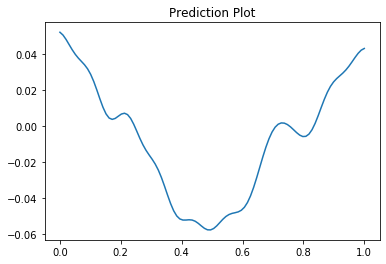

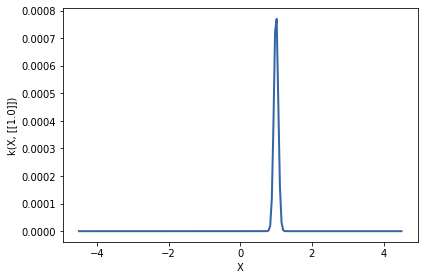

Iteration: 16 of 75


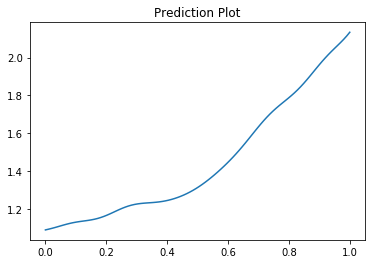

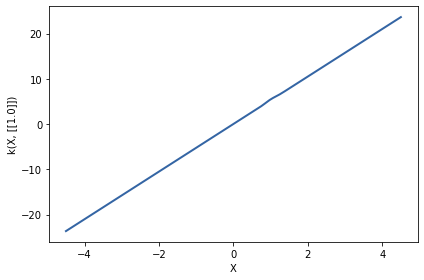

Iteration: 17 of 75


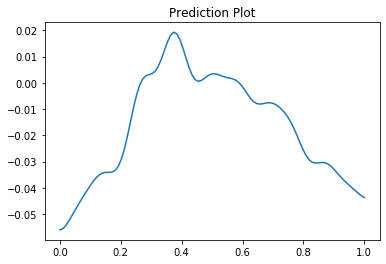

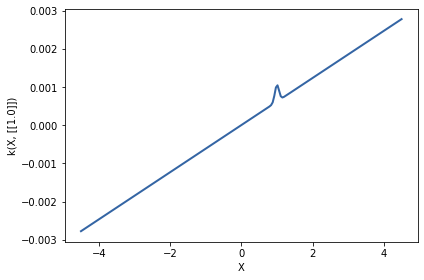

Iteration: 18 of 75


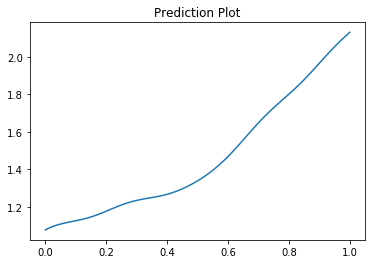

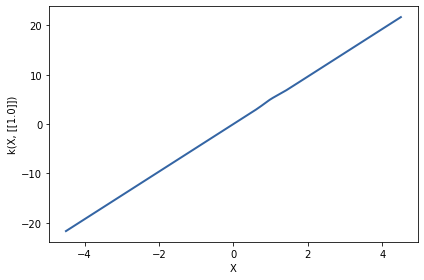

Iteration: 19 of 75


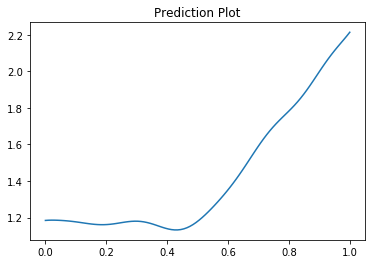

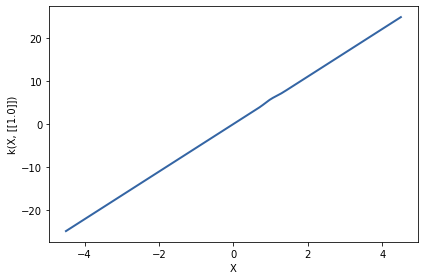

Iteration: 20 of 75


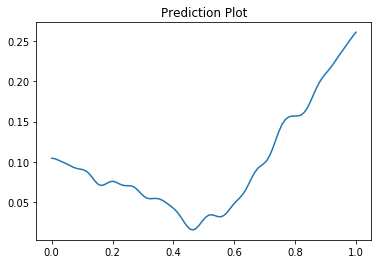

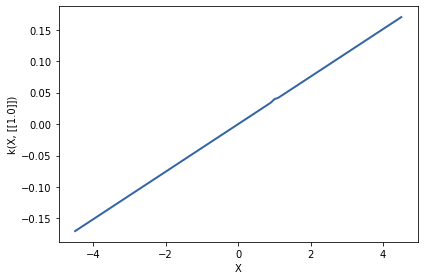

Iteration: 21 of 75


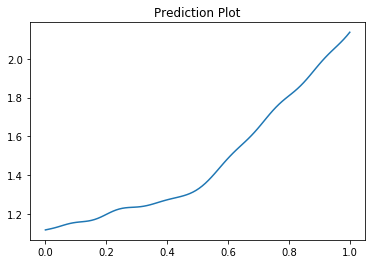

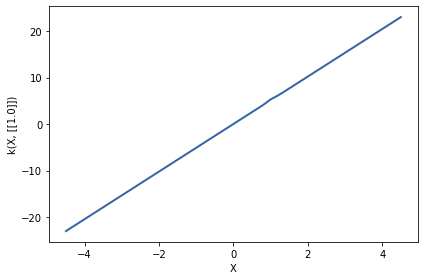

Iteration: 22 of 75


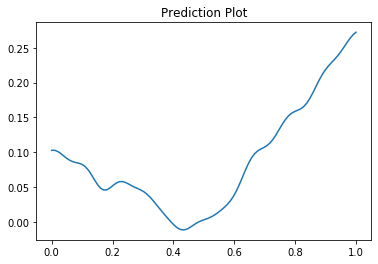

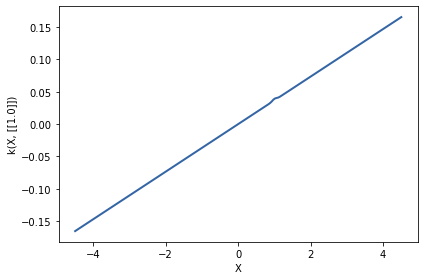

Iteration: 23 of 75


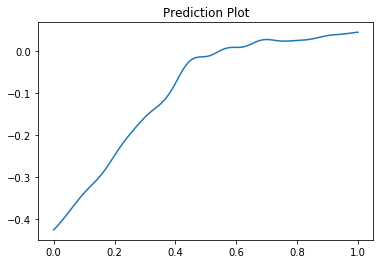

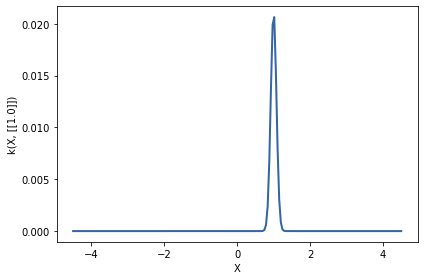

Iteration: 24 of 75


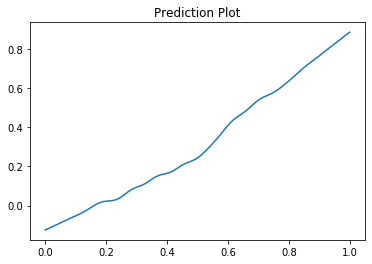

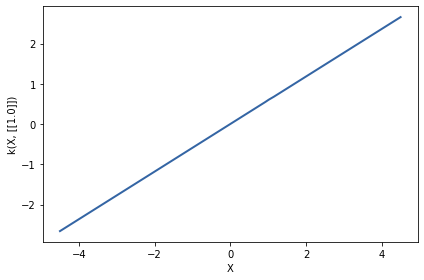

Iteration: 25 of 75


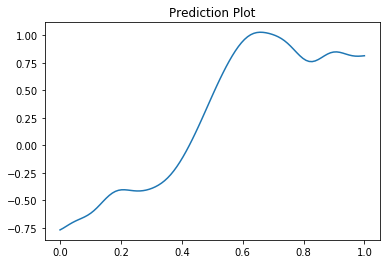

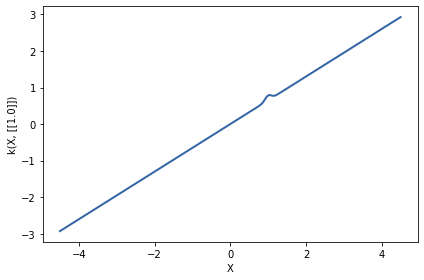

Iteration: 26 of 75


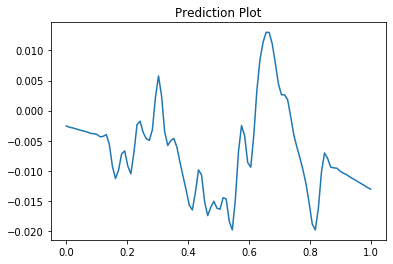

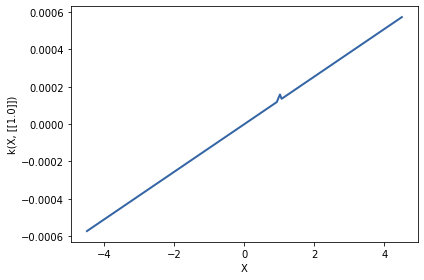

Iteration: 27 of 75


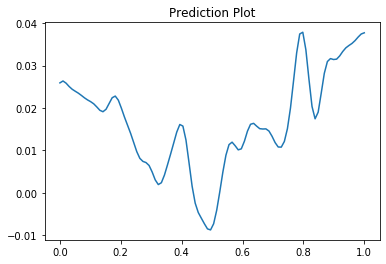

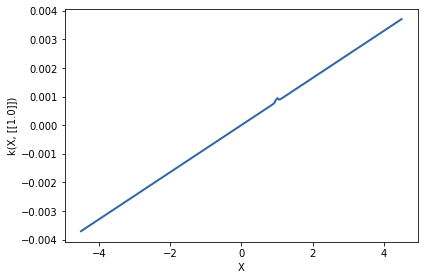

Iteration: 28 of 75


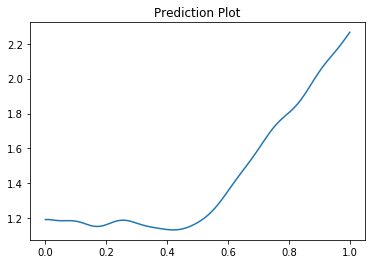

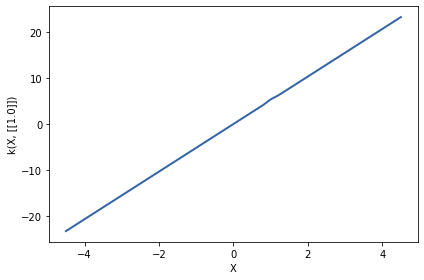

Iteration: 29 of 75


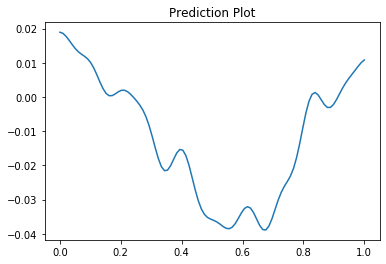

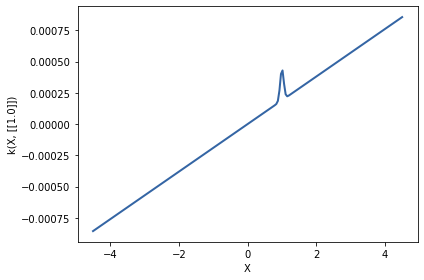

Iteration: 30 of 75


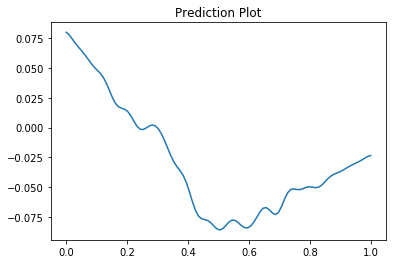

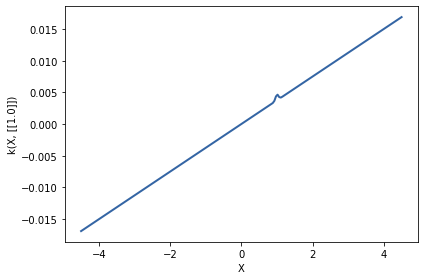

Iteration: 31 of 75


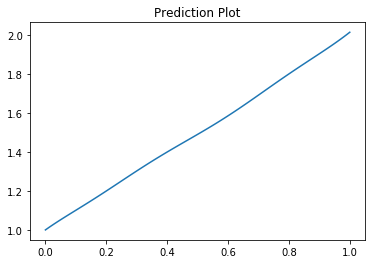

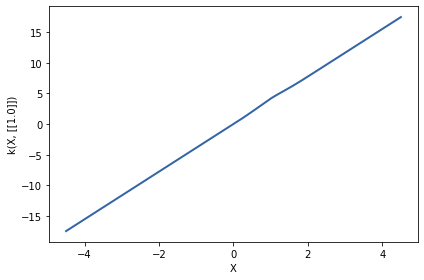

Iteration: 32 of 75


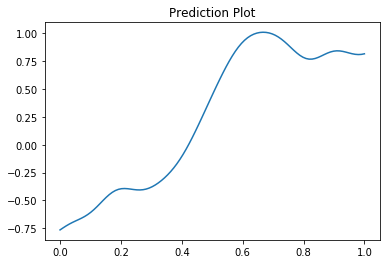

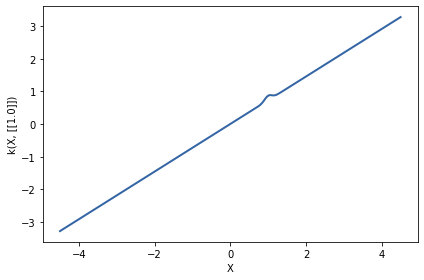

Iteration: 33 of 75


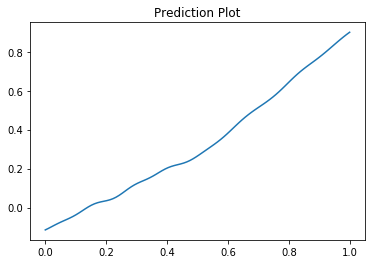

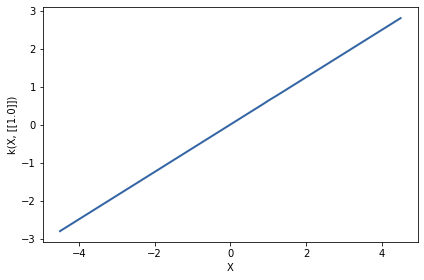

Iteration: 34 of 75


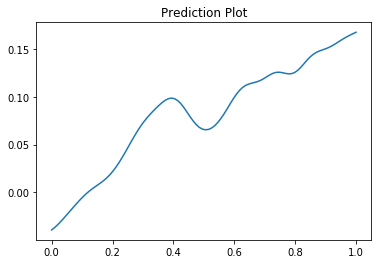

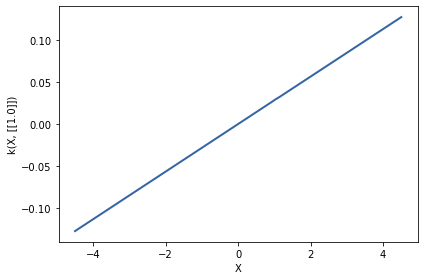

Iteration: 35 of 75


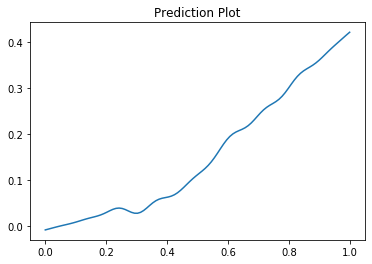

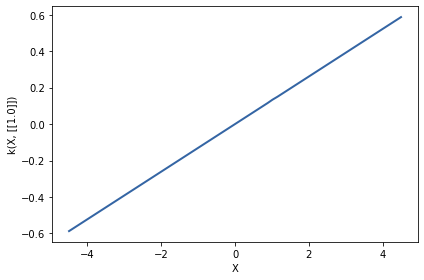

Iteration: 36 of 75


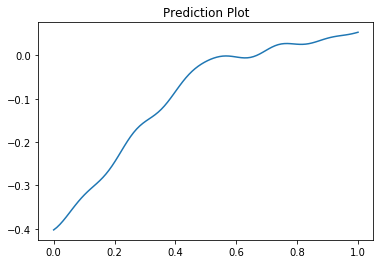

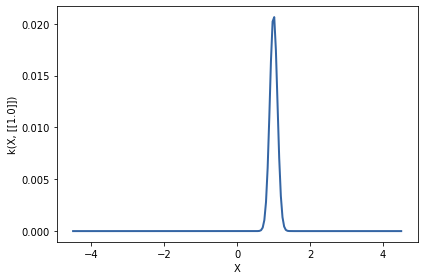

Iteration: 37 of 75


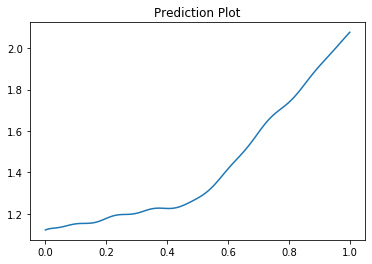

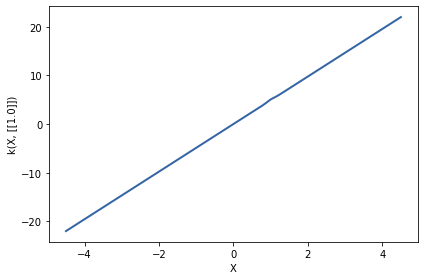

Iteration: 38 of 75


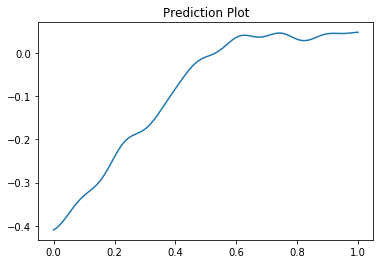

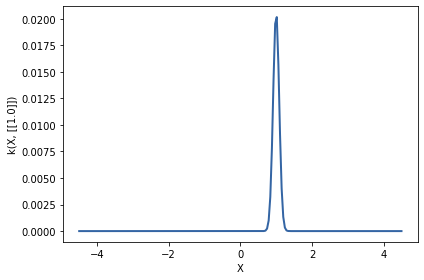

Iteration: 39 of 75


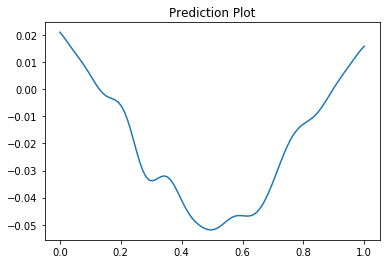

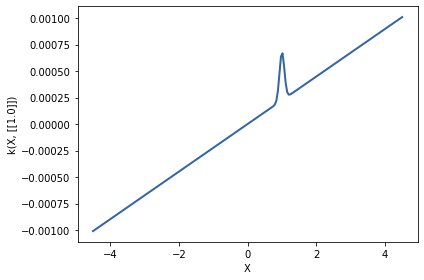

Iteration: 40 of 75


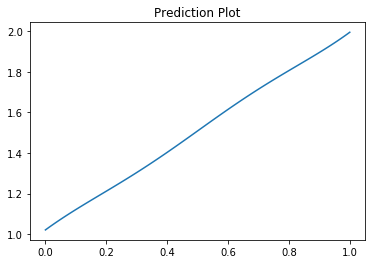

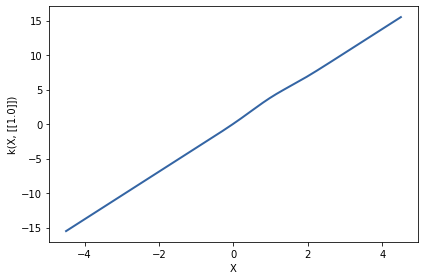

Iteration: 41 of 75


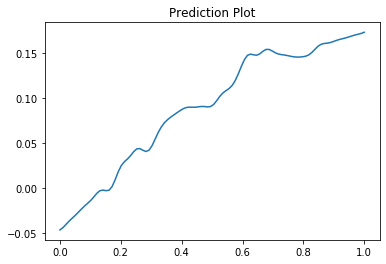

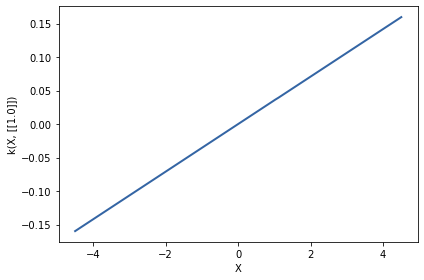

Iteration: 42 of 75


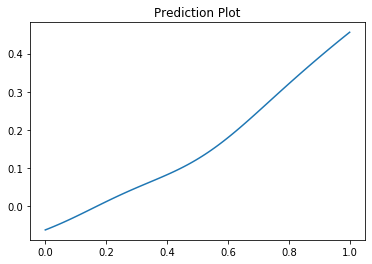

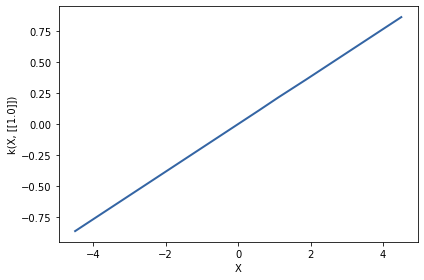

Iteration: 43 of 75


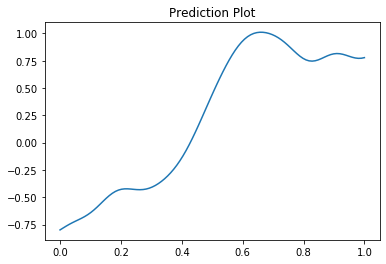

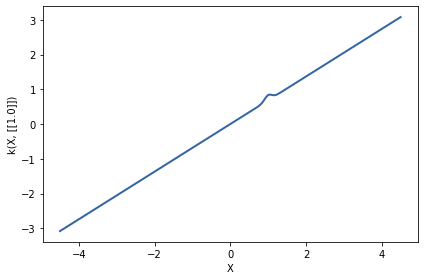

Iteration: 44 of 75


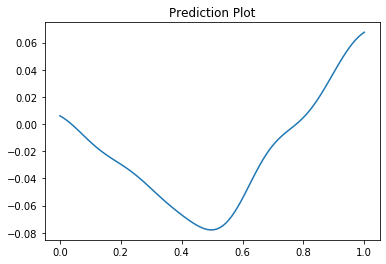

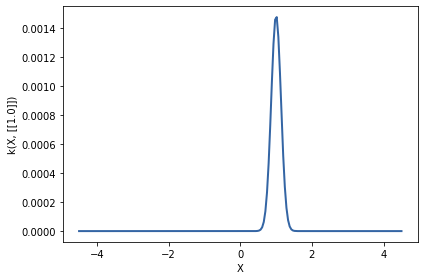

Iteration: 45 of 75


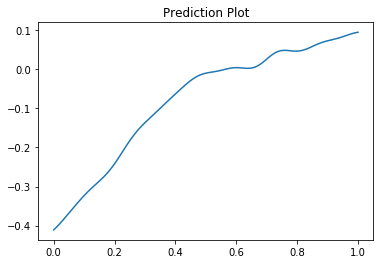

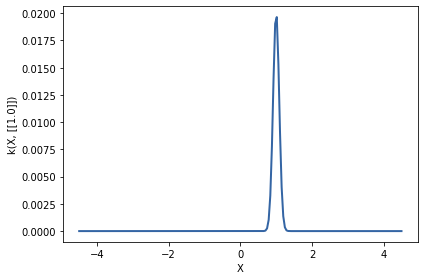

Iteration: 46 of 75


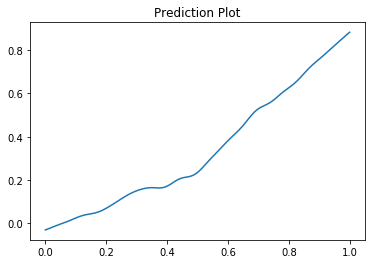

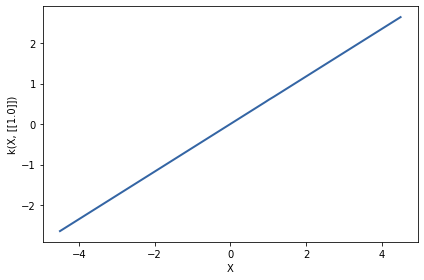

Iteration: 47 of 75


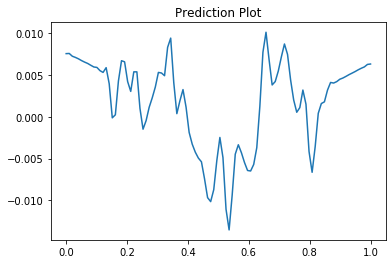

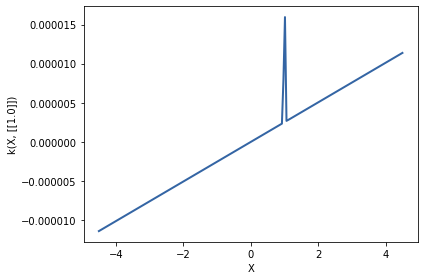

Iteration: 48 of 75


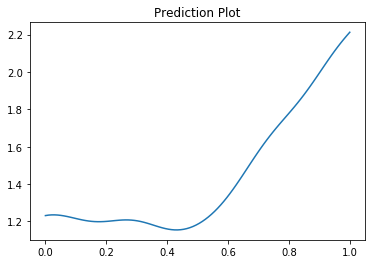

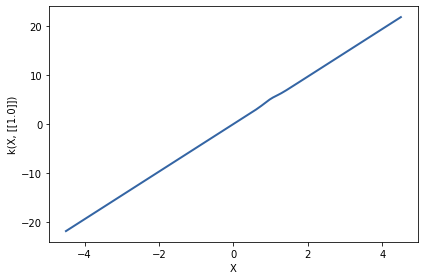

Iteration: 49 of 75


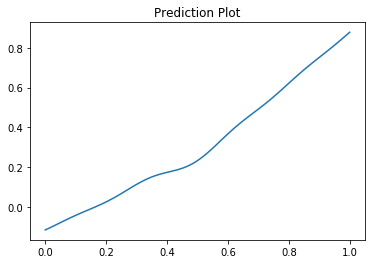

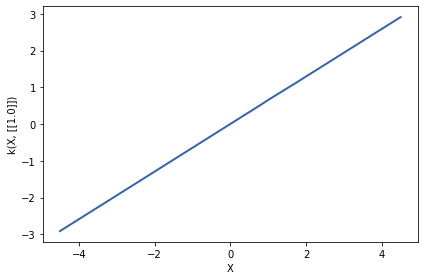

Iteration: 50 of 75


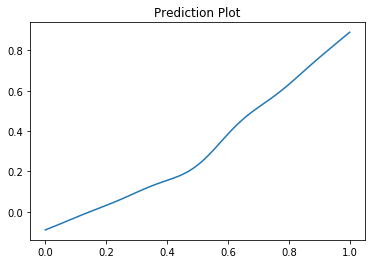

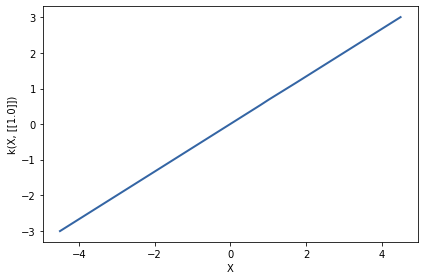

Iteration: 51 of 75


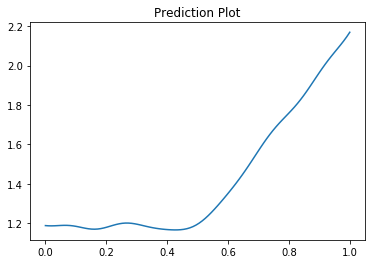

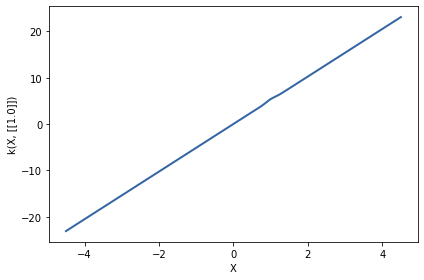

Iteration: 52 of 75


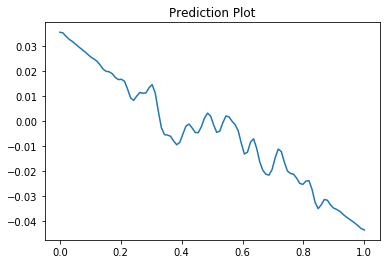

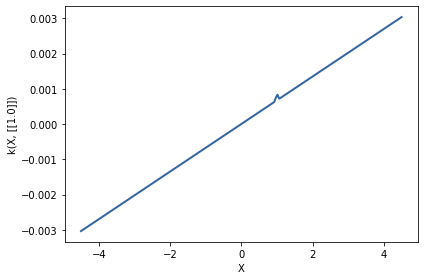

Iteration: 53 of 75


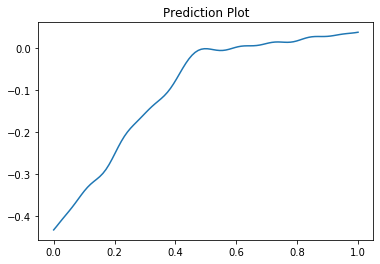

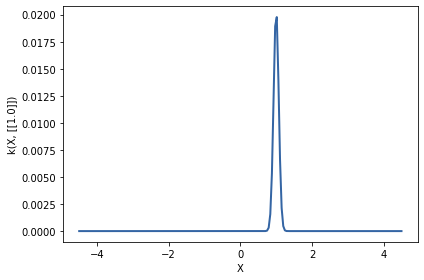

Iteration: 54 of 75


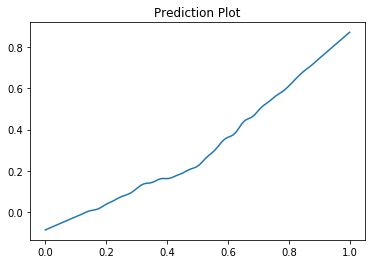

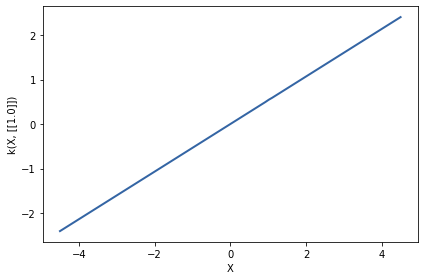

Iteration: 55 of 75


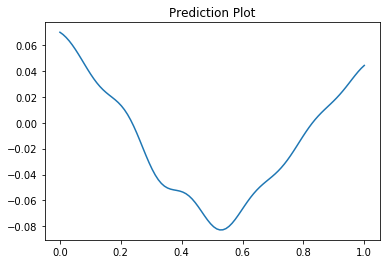

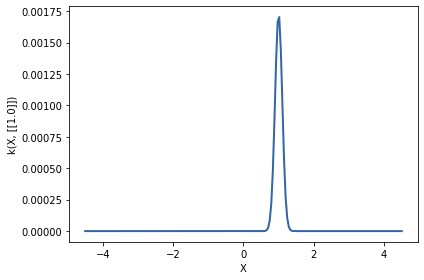

Iteration: 56 of 75


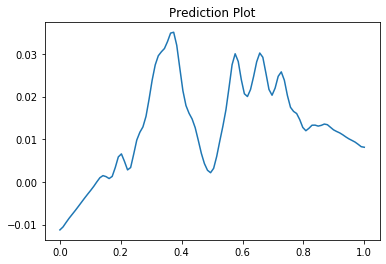

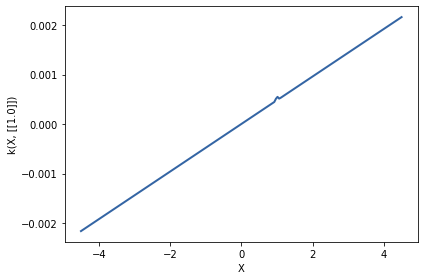

Iteration: 57 of 75


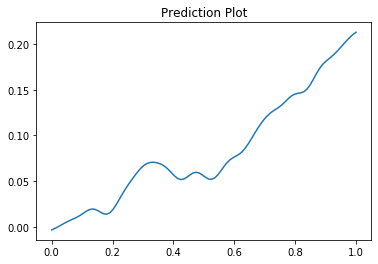

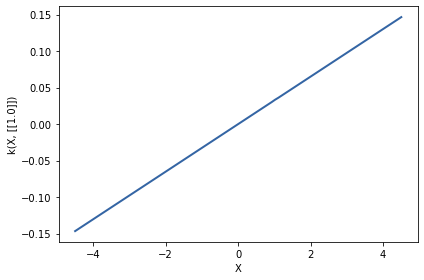

Iteration: 58 of 75


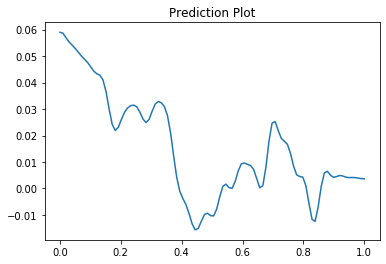

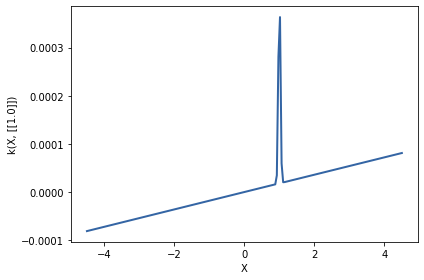

Iteration: 59 of 75


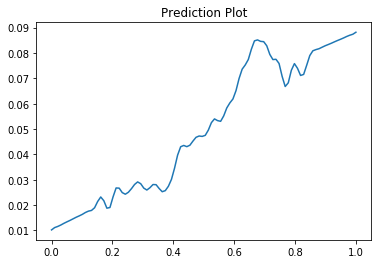

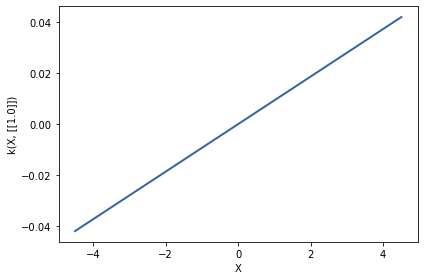

Iteration: 60 of 75


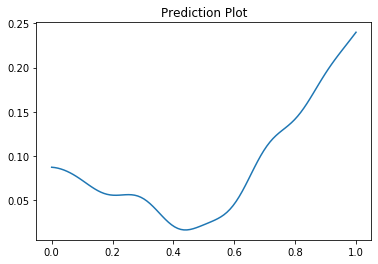

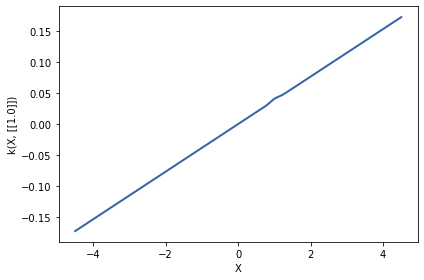

Iteration: 61 of 75


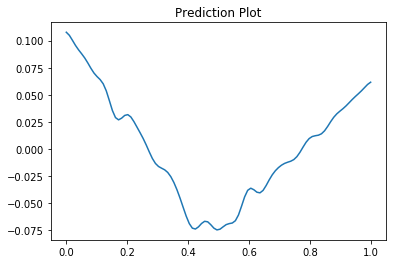

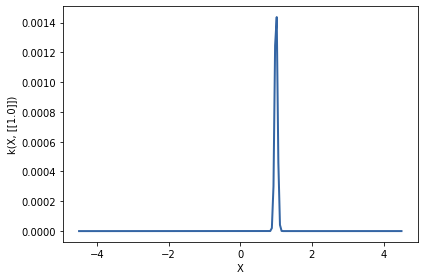

Iteration: 62 of 75


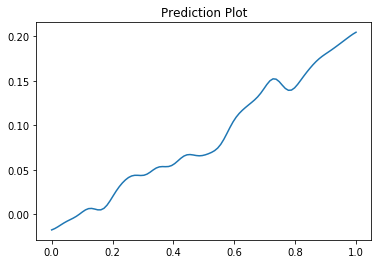

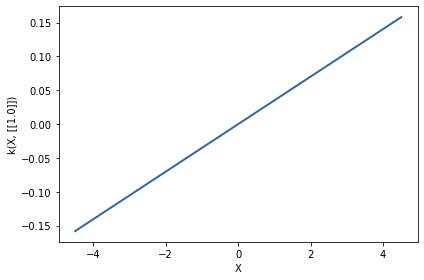

Iteration: 63 of 75


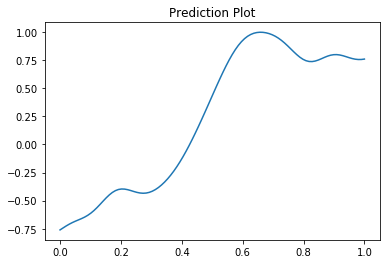

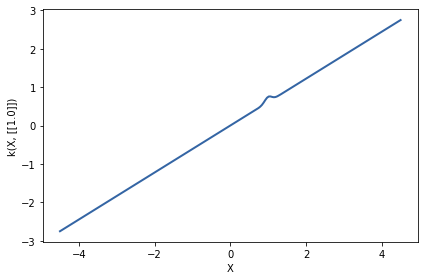

Iteration: 64 of 75


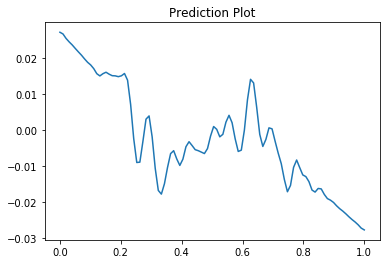

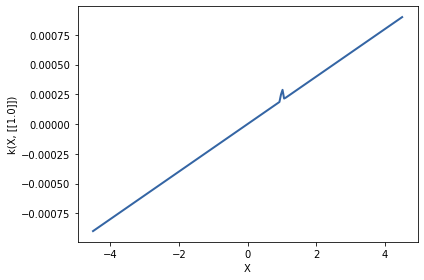

Iteration: 65 of 75


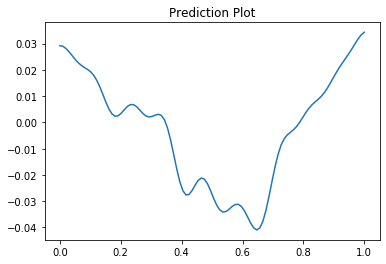

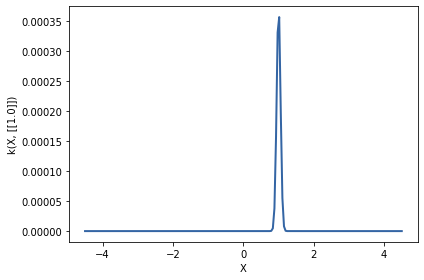

Iteration: 66 of 75


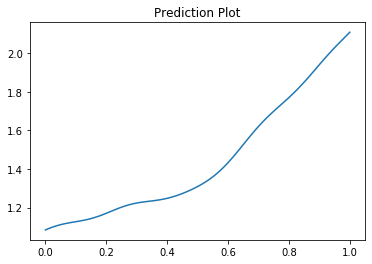

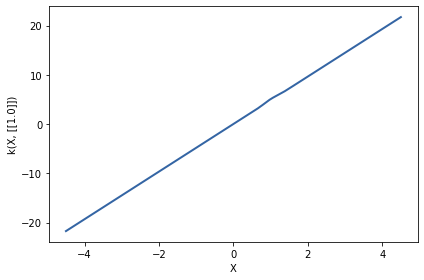

Iteration: 67 of 75


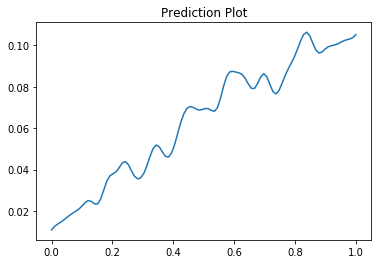

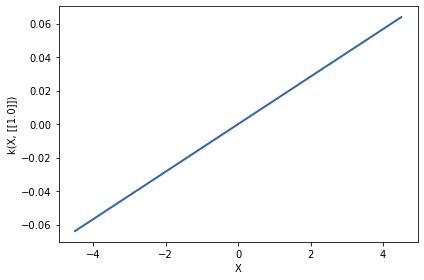

Iteration: 68 of 75


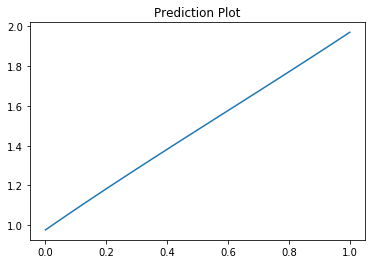

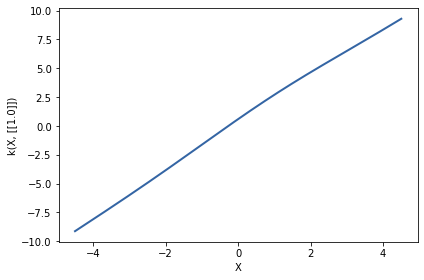

Iteration: 69 of 75


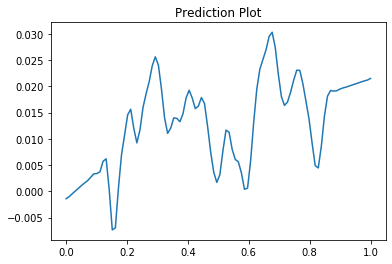

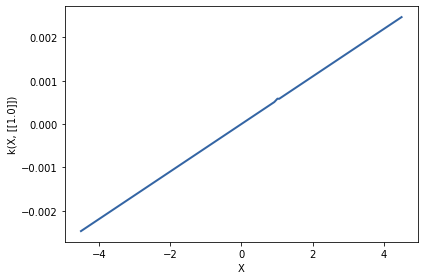

Iteration: 70 of 75


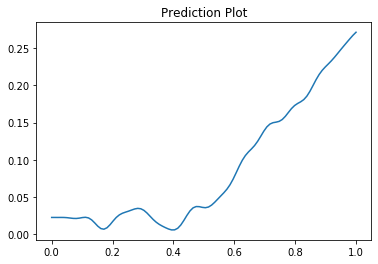

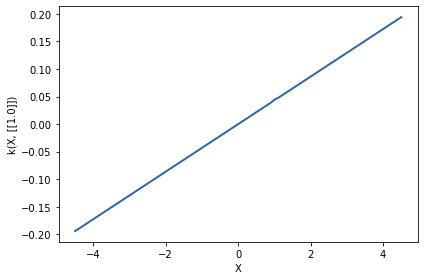

Iteration: 71 of 75


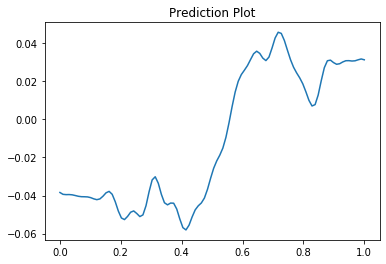

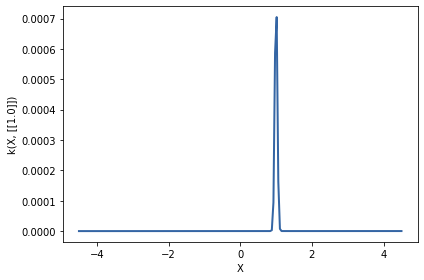

Iteration: 72 of 75


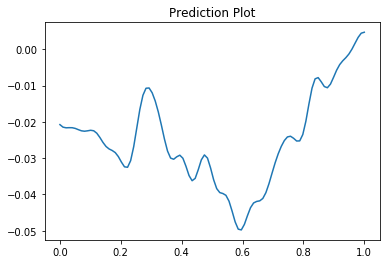

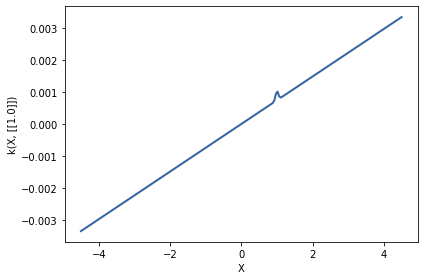

Iteration: 73 of 75


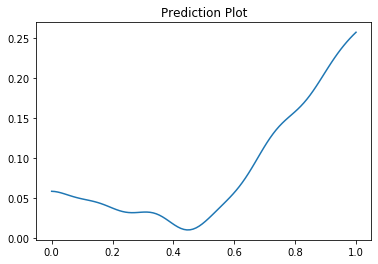

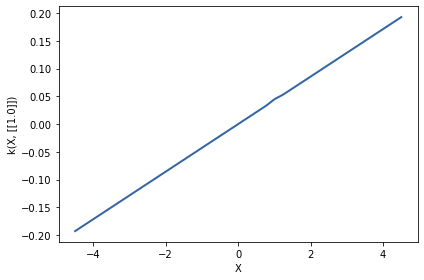

Iteration: 74 of 75


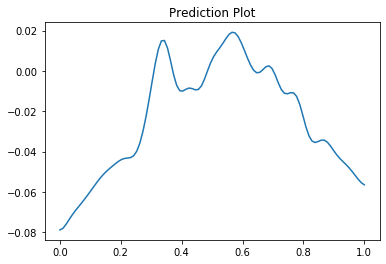

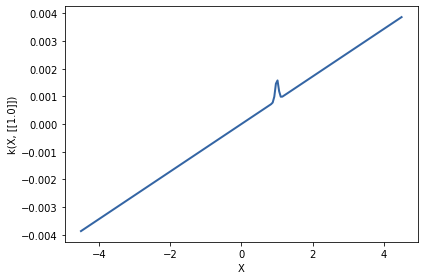

Iteration: 75 of 75


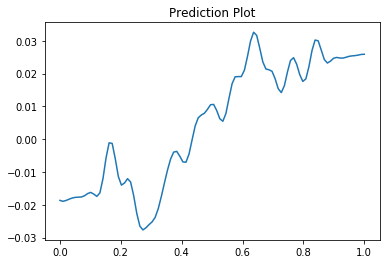

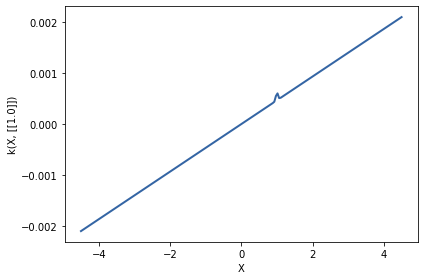

In [394]:
predicted = []
x_d = np.linspace(0,1,100)[:, None]
for x in range(rows):
    print(f'Iteration: {x+1} of {rows}')
    deco = seasonal_decompose(data.iloc[x,1:101].T, model='additive', freq=30, extrapolate_trend='freq')
    y_d = deco.trend.values[:, None]
    decision = run_model(x_d,y_d)
    predicted.append(decision)

In [395]:
# x = np.linspace(0,1,100).reshape(-1,1)
# predicted = []
# for r in range(rows):
#     print(f'Iteration: {r} of {rows}')
#     id_row = data.iloc[r,0]
#     y = non_seasonal.iloc[r,0:100].values[:,None]
#     decision = run_model(x,y)
#     predicted.append(decision)

In [396]:
print(predicted)

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

results = confusion_matrix(actual, predicted) 
print(results)
print('Accuracy Score :', accuracy_score(actual, predicted))
print ('The Report : ')
print (classification_report(actual, predicted))

[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[[38 11]
 [10 16]]
Accuracy Score : 0.72
The Report : 
              precision    recall  f1-score   support

           0       0.79      0.78      0.78        49
           1       0.59      0.62      0.60        26

    accuracy                           0.72        75
   macro avg       0.69      0.70      0.69        75
weighted avg       0.72      0.72      0.72        75



Iteration: 120 of 120


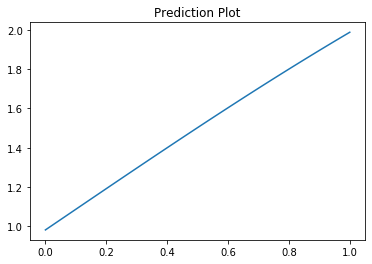

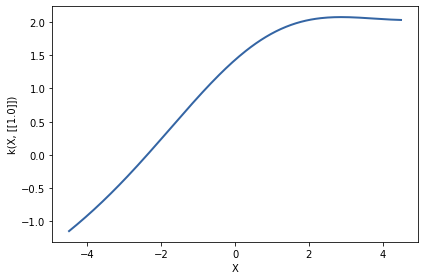

Decision is 1 for Id 0
Iteration: 120 of 120


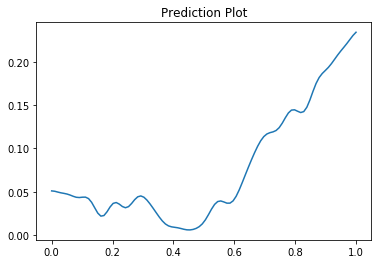

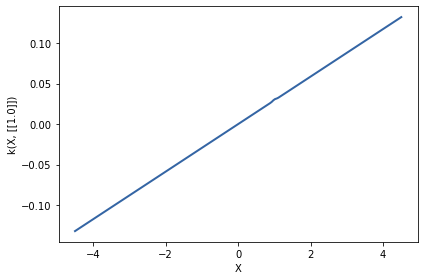

Decision is 0 for Id 1
Iteration: 120 of 120


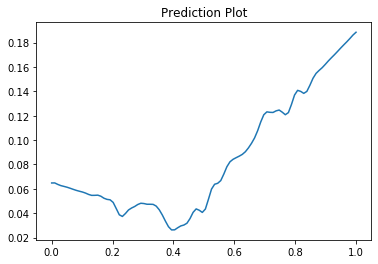

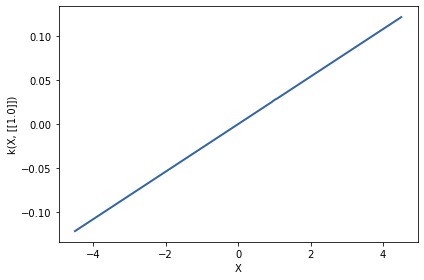

Decision is 0 for Id 2
Iteration: 120 of 120


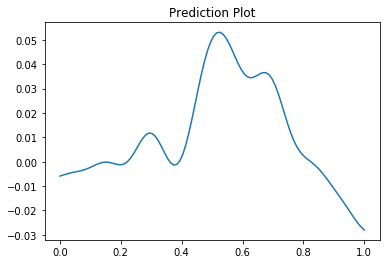

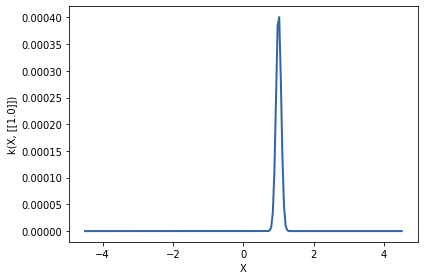

Decision is 0 for Id 3
Iteration: 120 of 120


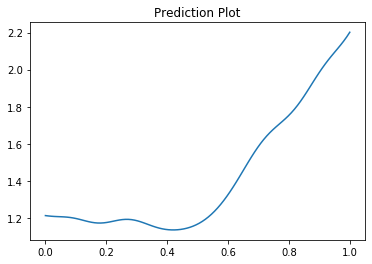

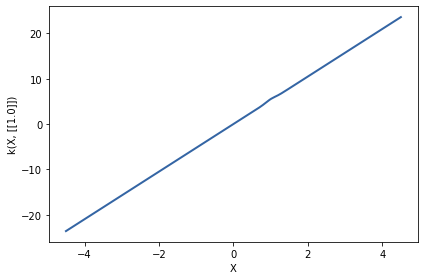

Decision is 0 for Id 4
Iteration: 120 of 120


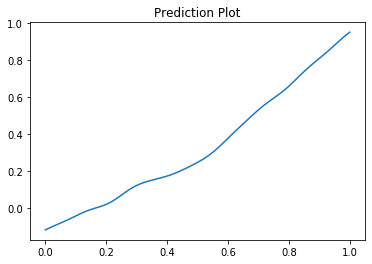

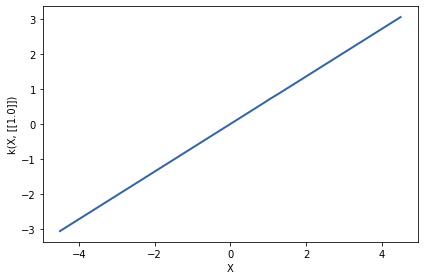

Decision is 1 for Id 5
Iteration: 120 of 120


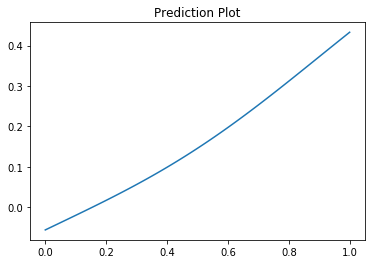

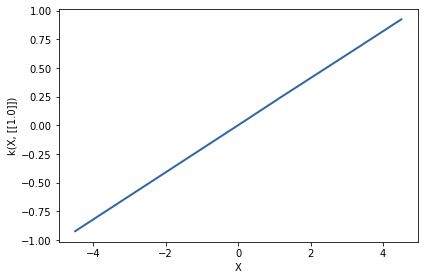

Decision is 1 for Id 6
Iteration: 120 of 120


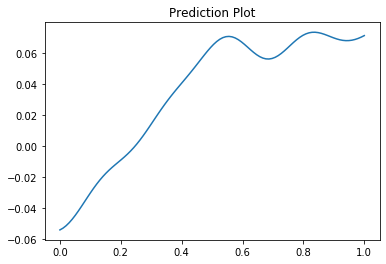

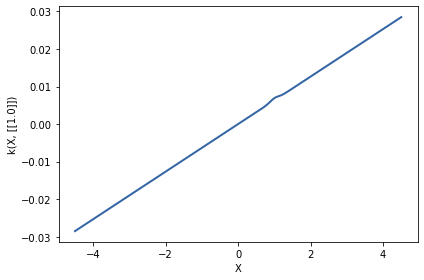

Decision is 0 for Id 7
Iteration: 120 of 120


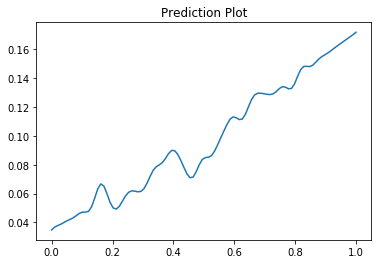

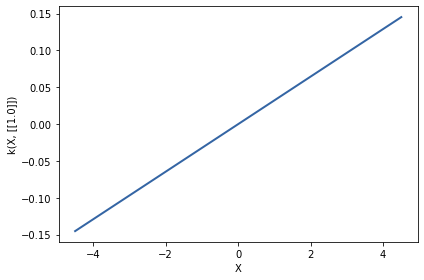

Decision is 0 for Id 8
Iteration: 120 of 120


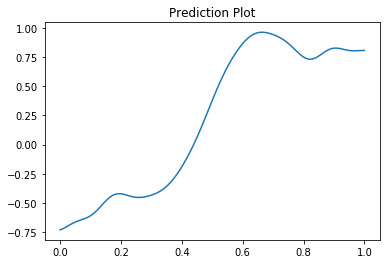

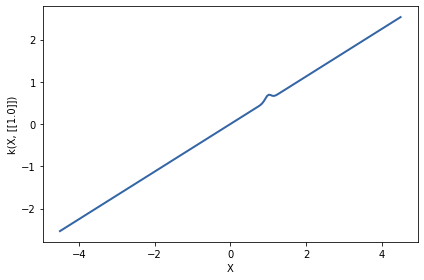

Decision is 0 for Id 9
Iteration: 120 of 120


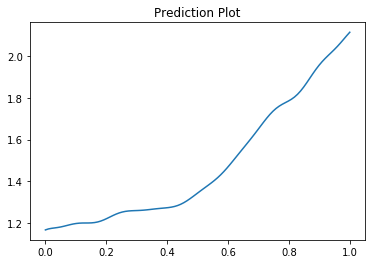

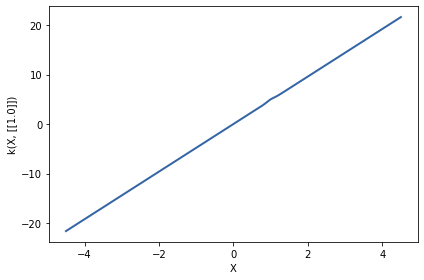

Decision is 1 for Id 10
Iteration: 120 of 120


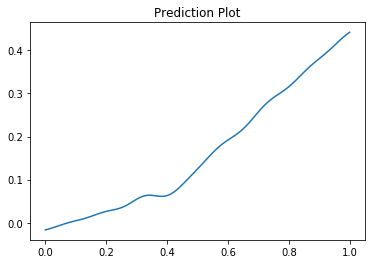

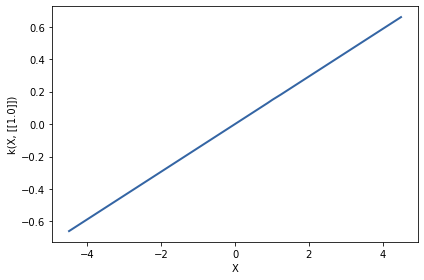

Decision is 1 for Id 11
Iteration: 120 of 120


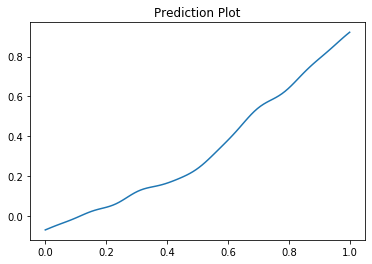

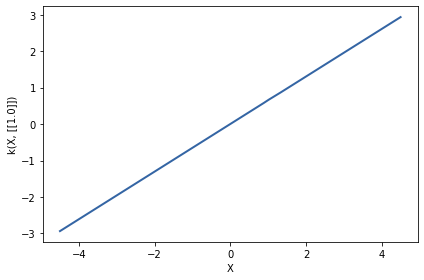

Decision is 1 for Id 12
Iteration: 120 of 120


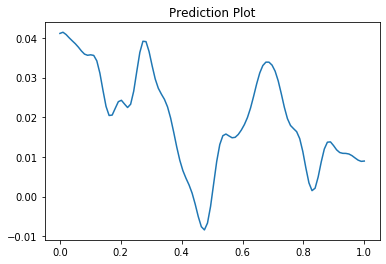

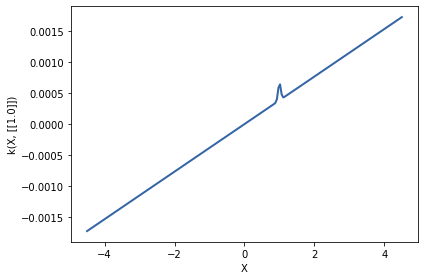

Decision is 0 for Id 13
Iteration: 120 of 120


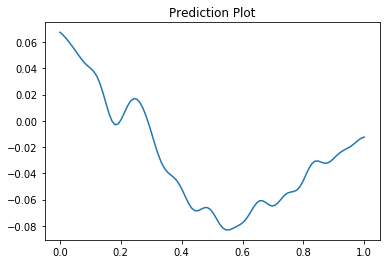

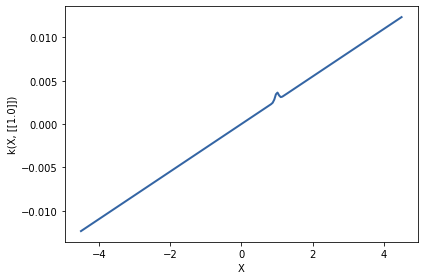

Decision is 0 for Id 14
Iteration: 120 of 120


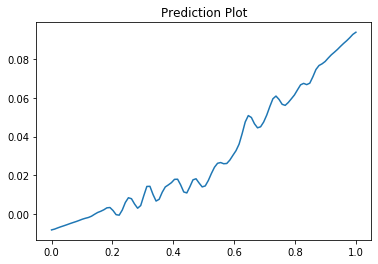

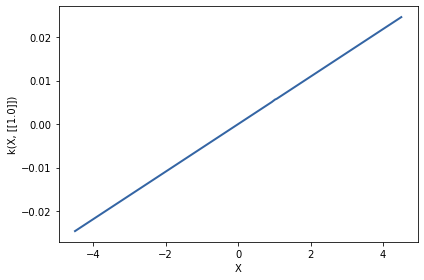

Decision is 0 for Id 15
Iteration: 120 of 120


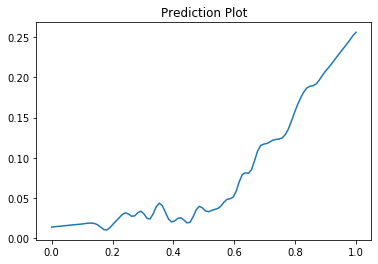

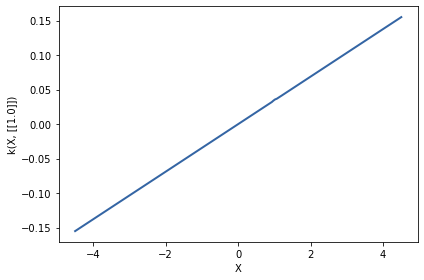

Decision is 0 for Id 16
Iteration: 120 of 120


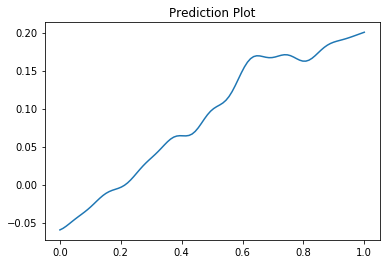

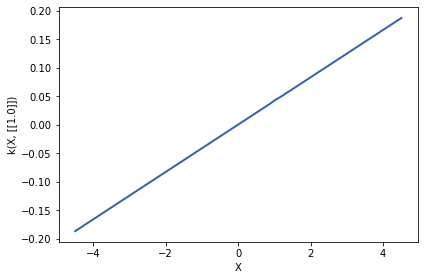

Decision is 1 for Id 17
Iteration: 120 of 120


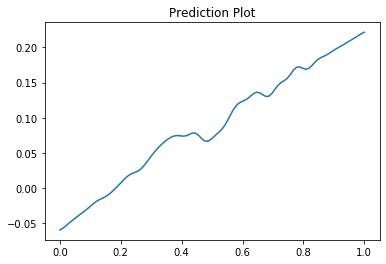

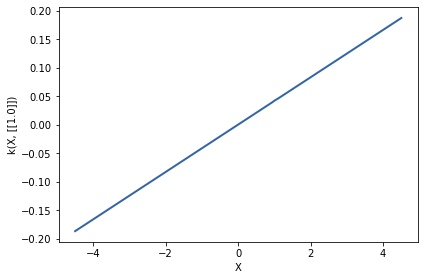

Decision is 1 for Id 18
Iteration: 120 of 120


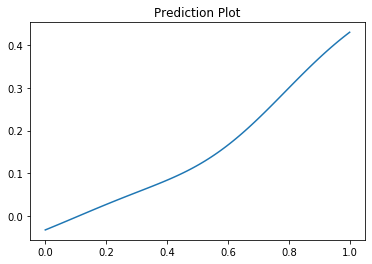

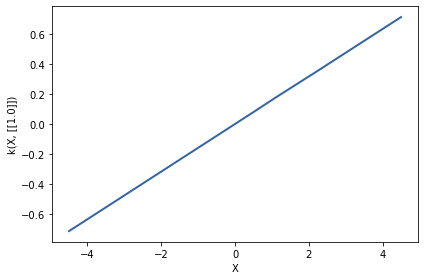

Decision is 1 for Id 19
Iteration: 120 of 120


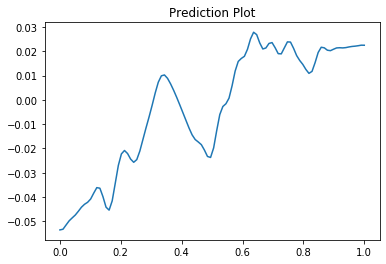

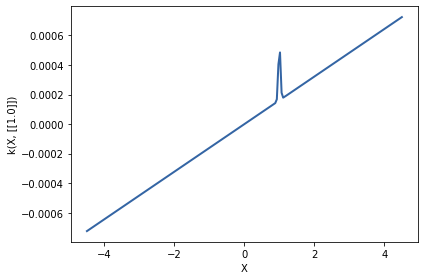

Decision is 0 for Id 20
Iteration: 120 of 120


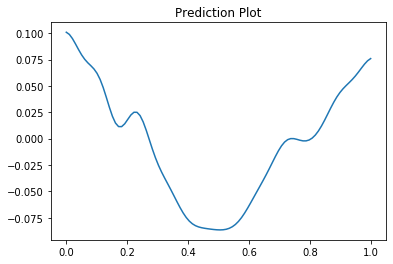

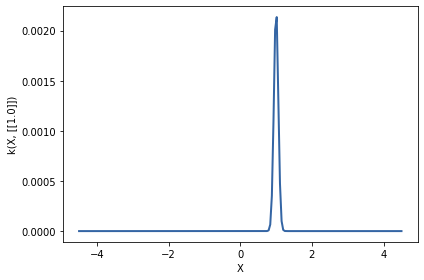

Decision is 0 for Id 21
Iteration: 120 of 120


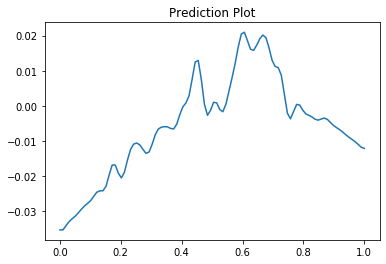

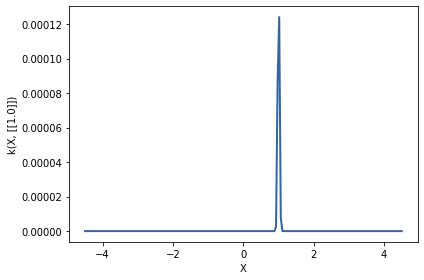

Decision is 0 for Id 22
Iteration: 120 of 120


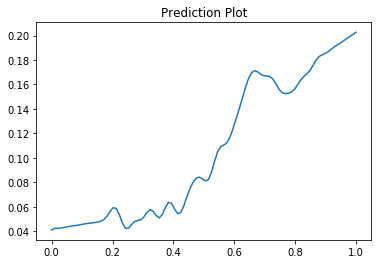

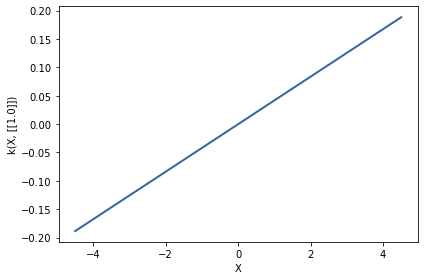

Decision is 0 for Id 23
Iteration: 120 of 120


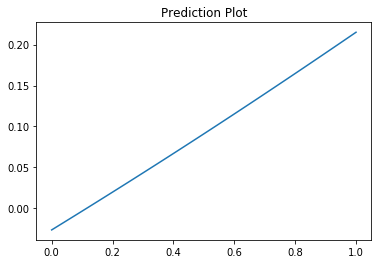

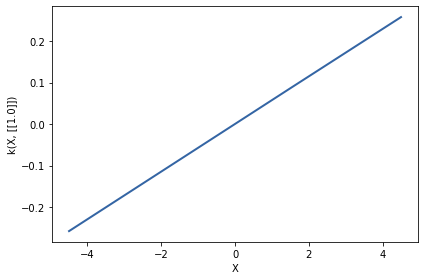

Decision is 1 for Id 24
Iteration: 120 of 120


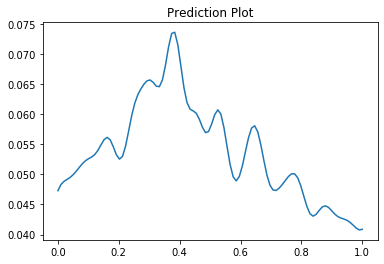

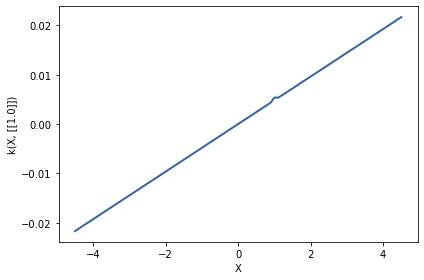

Decision is 0 for Id 25
Iteration: 120 of 120


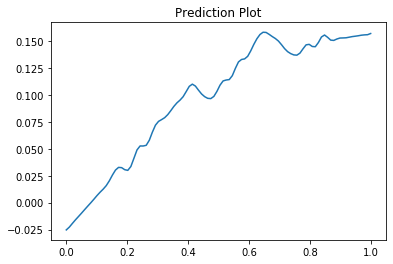

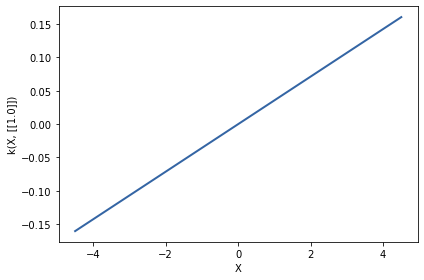

Decision is 0 for Id 26
Iteration: 120 of 120


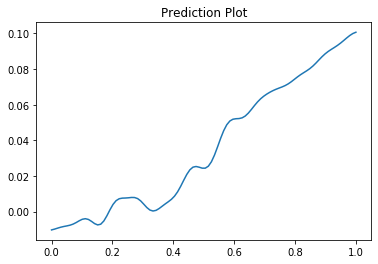

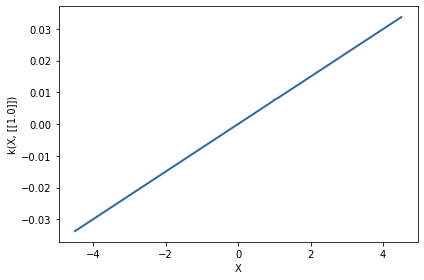

Decision is 0 for Id 27
Iteration: 120 of 120


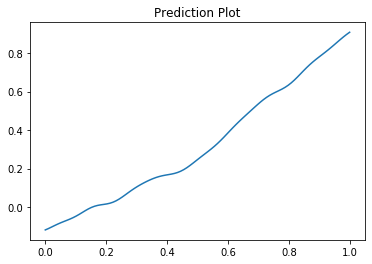

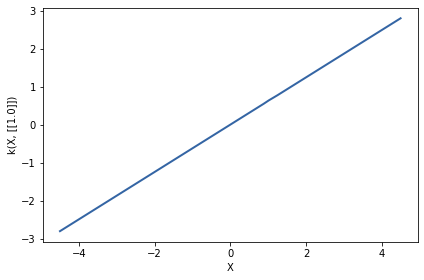

Decision is 1 for Id 28
Iteration: 120 of 120


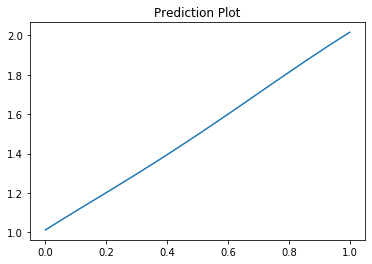

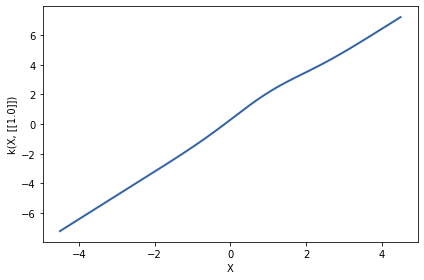

Decision is 1 for Id 29
Iteration: 120 of 120


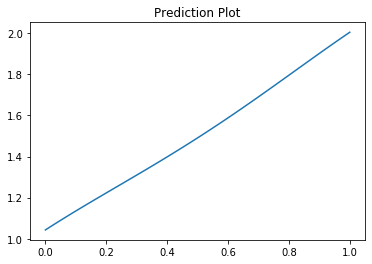

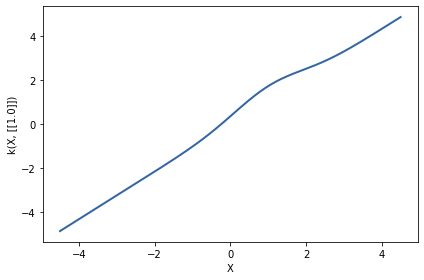

Decision is 1 for Id 30
Iteration: 120 of 120


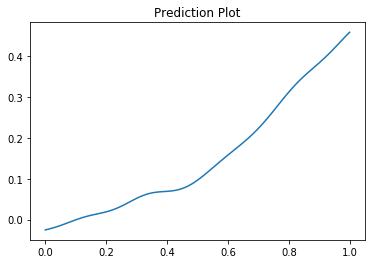

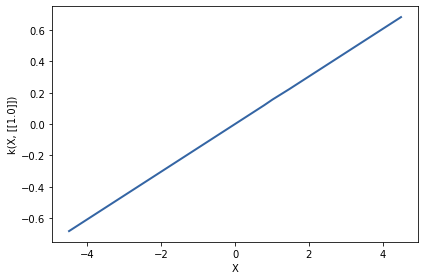

Decision is 1 for Id 31
Iteration: 120 of 120


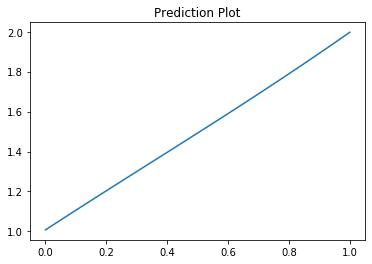

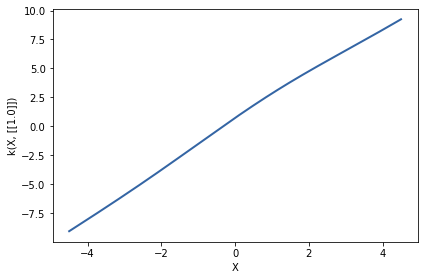

Decision is 1 for Id 32
Iteration: 120 of 120


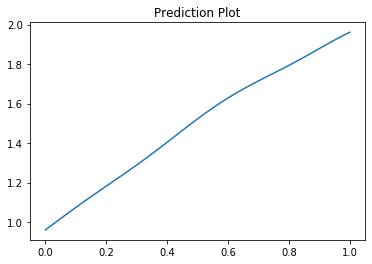

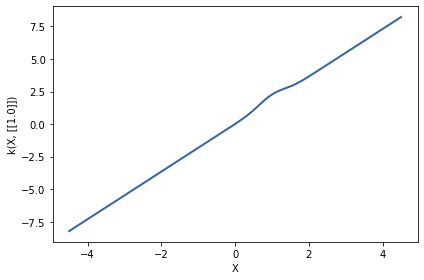

Decision is 1 for Id 33
Iteration: 120 of 120


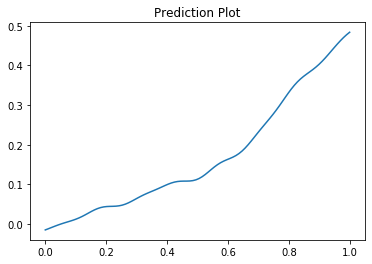

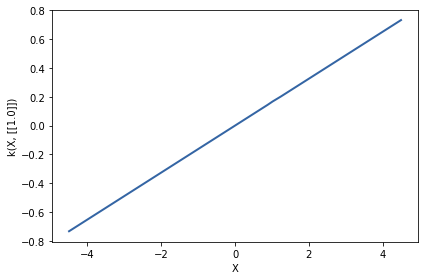

Decision is 1 for Id 34
Iteration: 120 of 120


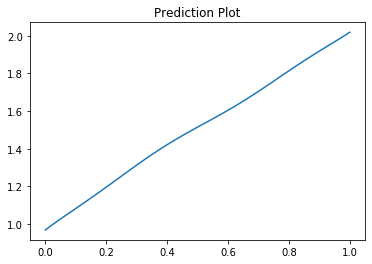

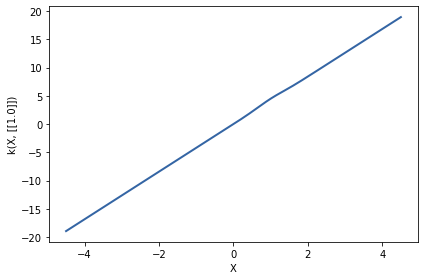

Decision is 1 for Id 35
Iteration: 120 of 120


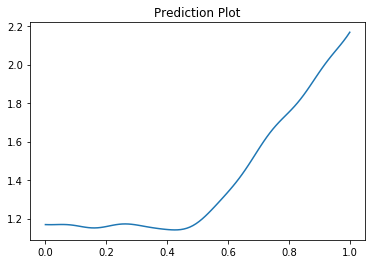

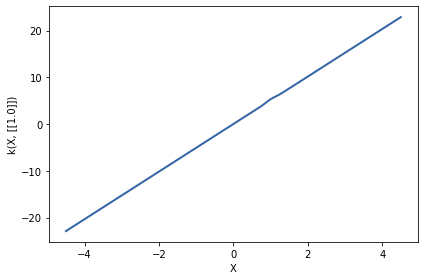

Decision is 0 for Id 36
Iteration: 120 of 120


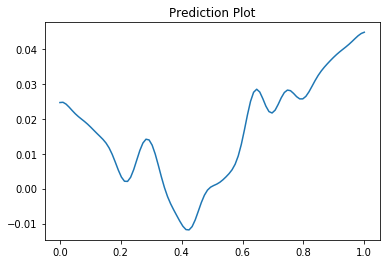

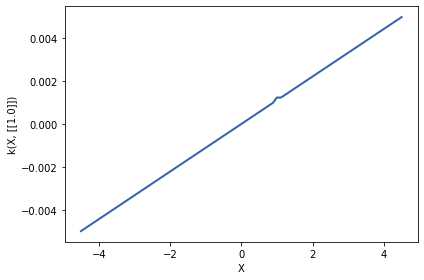

Decision is 0 for Id 37
Iteration: 120 of 120


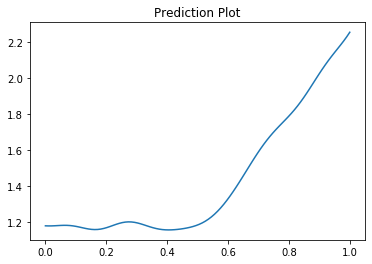

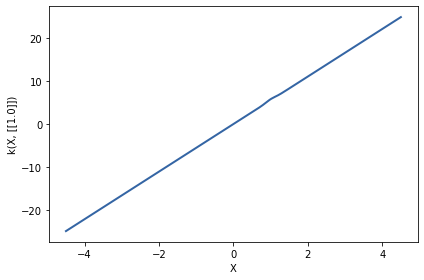

Decision is 0 for Id 38
Iteration: 120 of 120


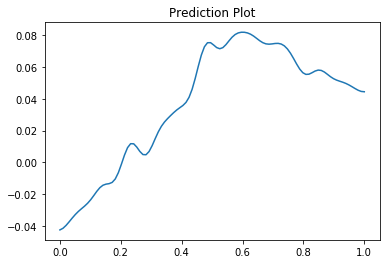

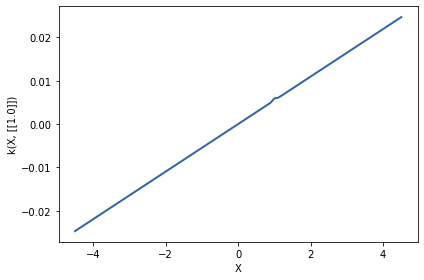

Decision is 0 for Id 39
Iteration: 120 of 120


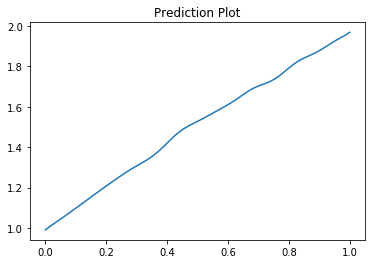

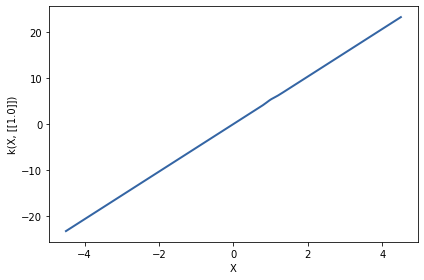

Decision is 1 for Id 40
Iteration: 120 of 120


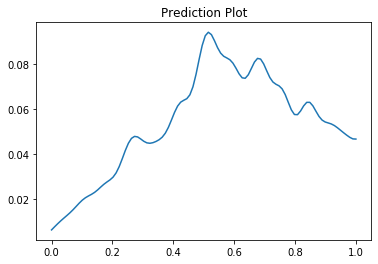

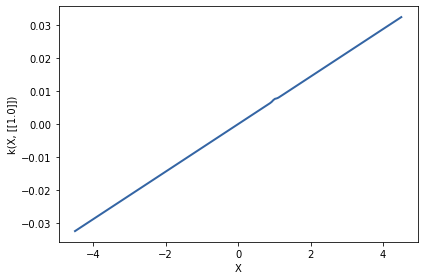

Decision is 0 for Id 41
Iteration: 120 of 120


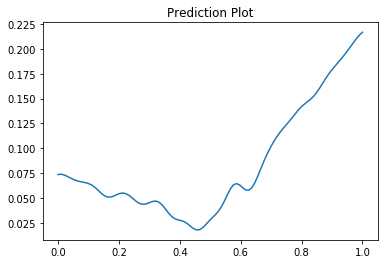

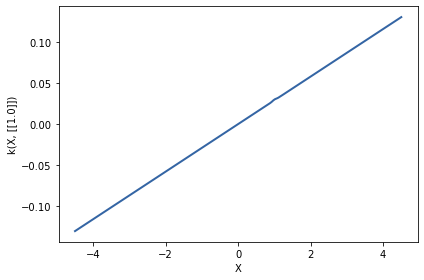

Decision is 0 for Id 42
Iteration: 120 of 120


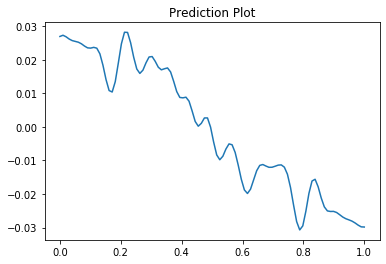

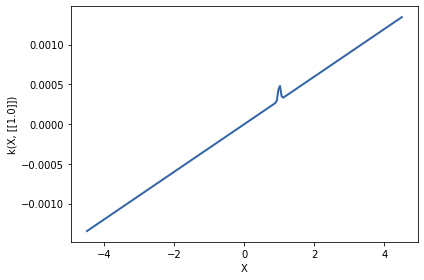

Decision is 0 for Id 43
Iteration: 120 of 120


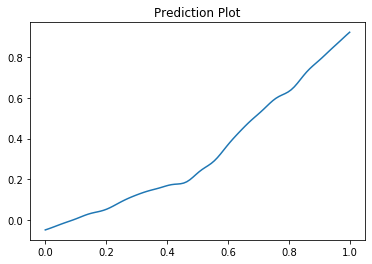

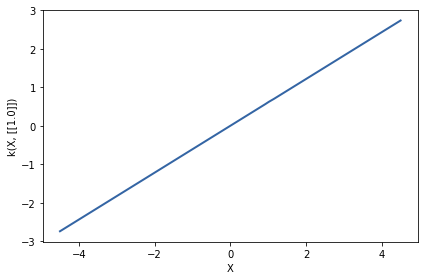

Decision is 1 for Id 44
Iteration: 120 of 120


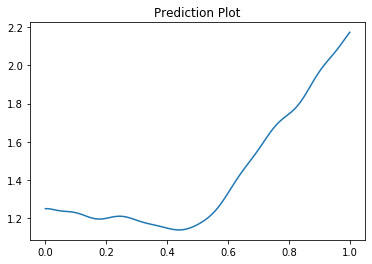

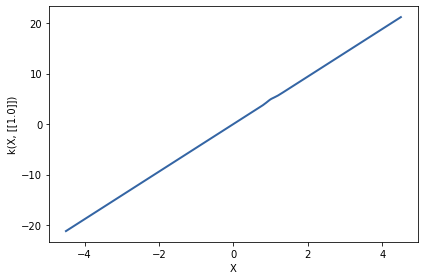

Decision is 0 for Id 45
Iteration: 120 of 120


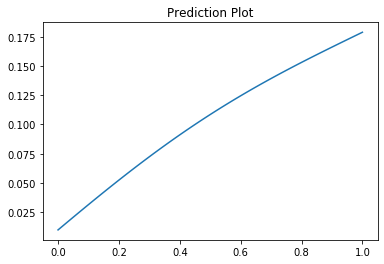

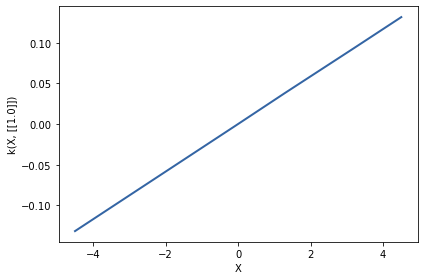

Decision is 1 for Id 46
Iteration: 120 of 120


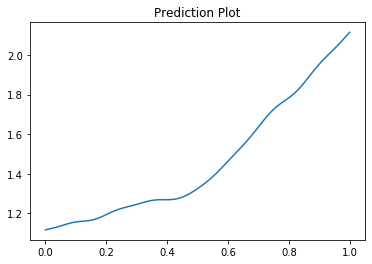

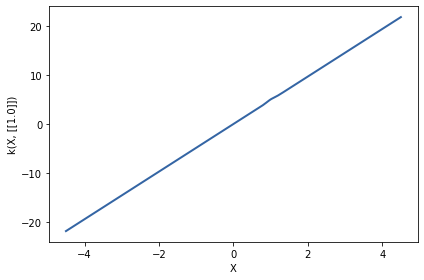

Decision is 1 for Id 47
Iteration: 120 of 120


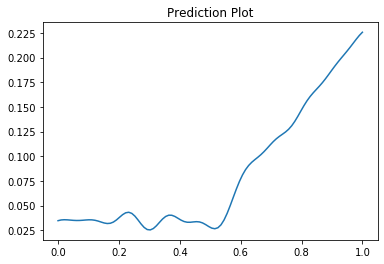

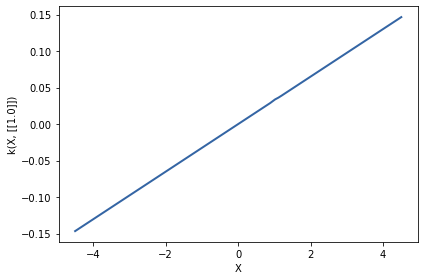

Decision is 0 for Id 48
Iteration: 120 of 120


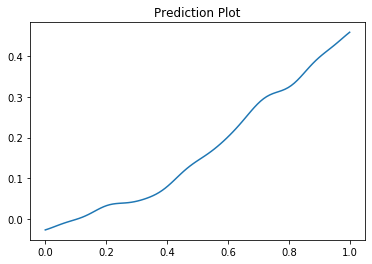

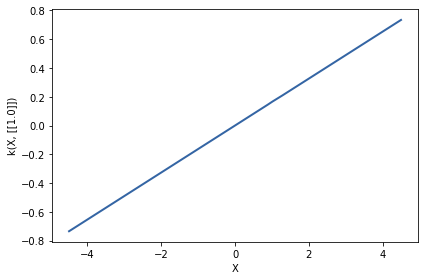

Decision is 1 for Id 49
Iteration: 120 of 120


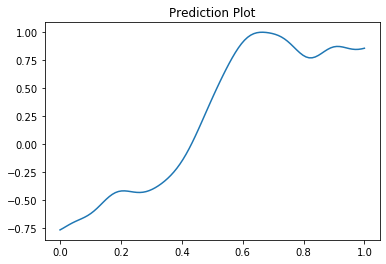

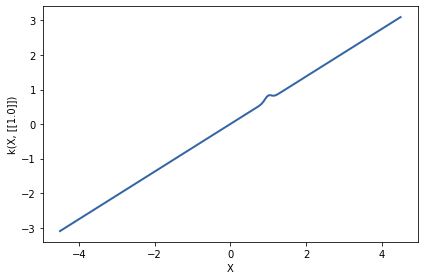

Decision is 0 for Id 50
Iteration: 120 of 120


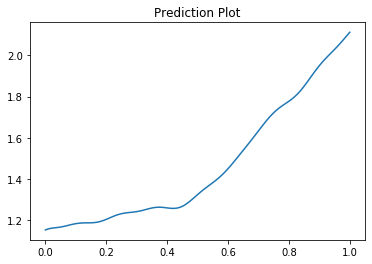

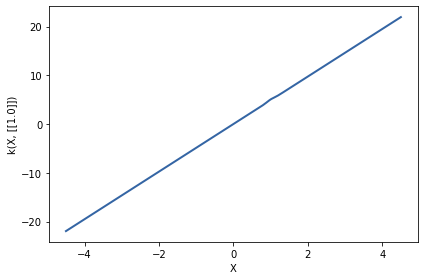

Decision is 1 for Id 51
Iteration: 120 of 120


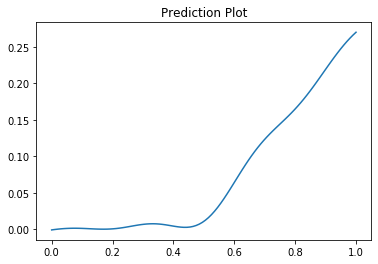

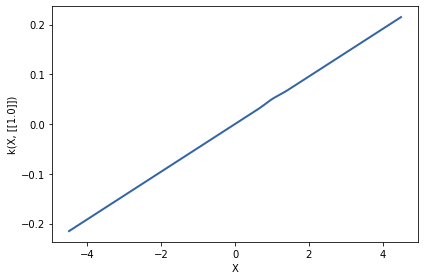

Decision is 0 for Id 52
Iteration: 120 of 120


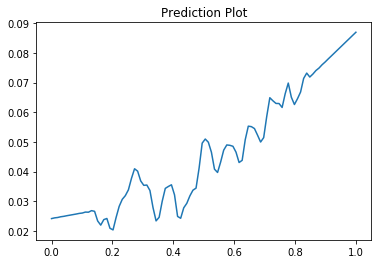

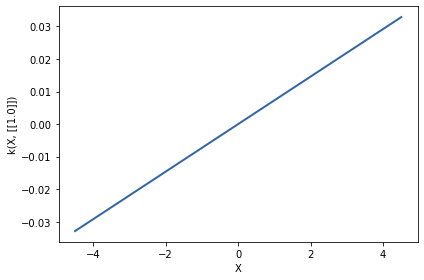

Decision is 0 for Id 53
Iteration: 120 of 120


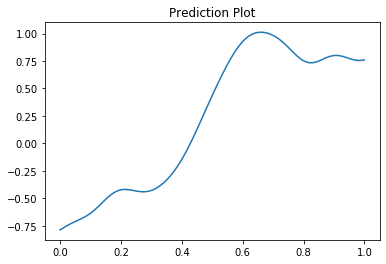

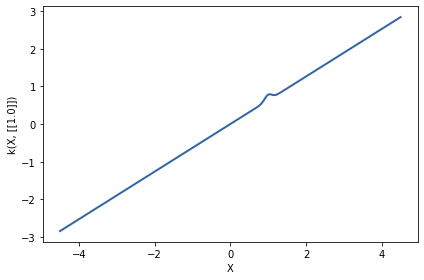

Decision is 0 for Id 54
Iteration: 120 of 120


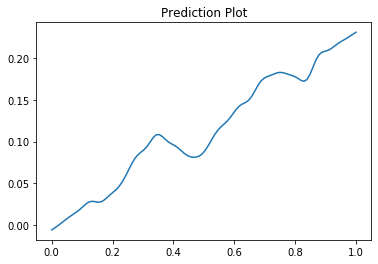

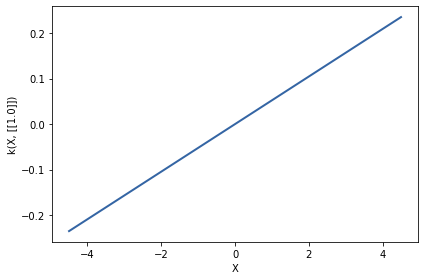

Decision is 0 for Id 55
Iteration: 120 of 120


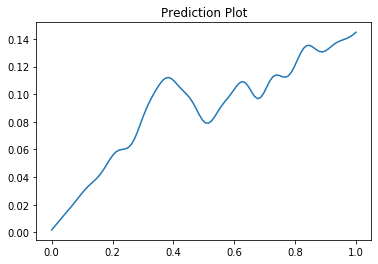

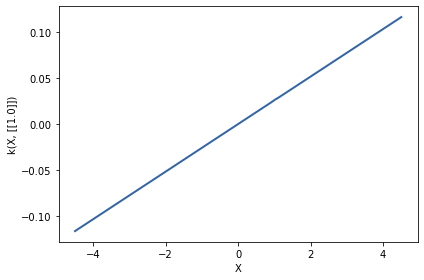

Decision is 0 for Id 56
Iteration: 120 of 120


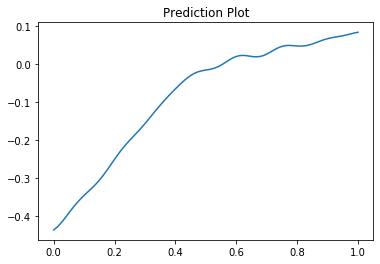

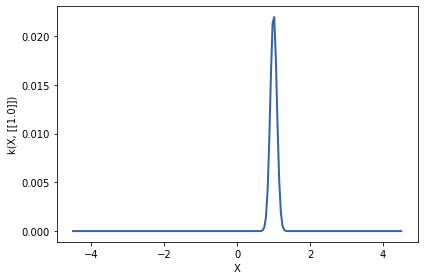

Decision is 1 for Id 57
Iteration: 120 of 120


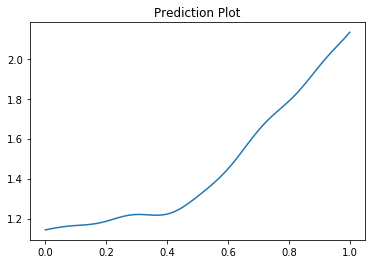

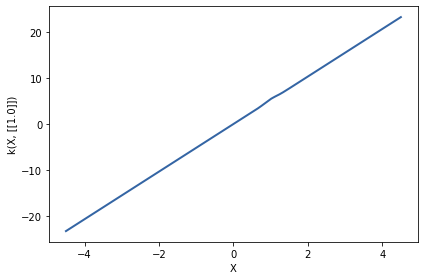

Decision is 1 for Id 58
Iteration: 120 of 120


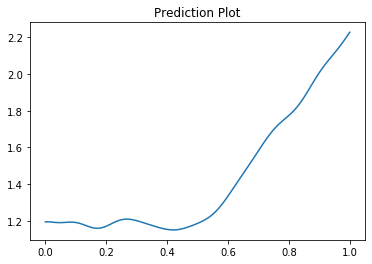

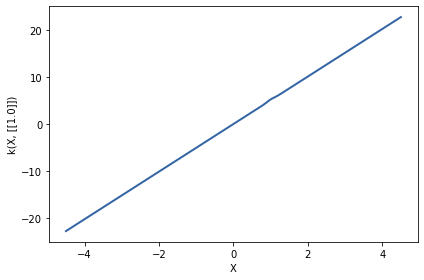

Decision is 0 for Id 59
Iteration: 120 of 120


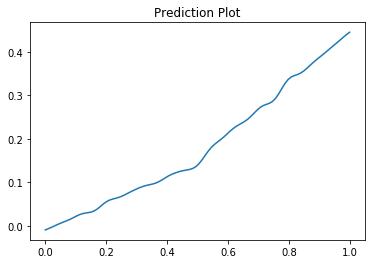

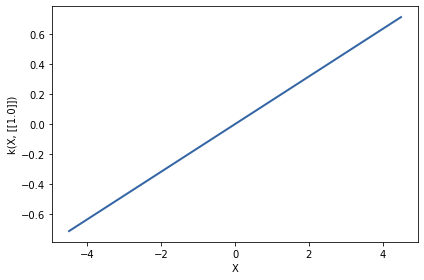

Decision is 1 for Id 60
Iteration: 120 of 120


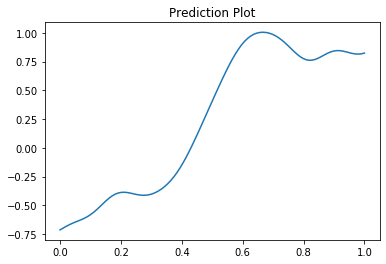

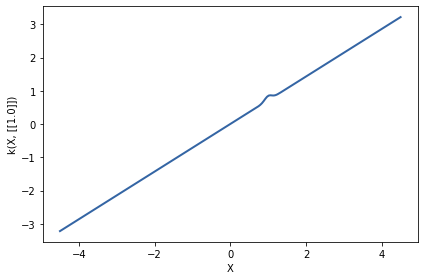

Decision is 0 for Id 61
Iteration: 120 of 120


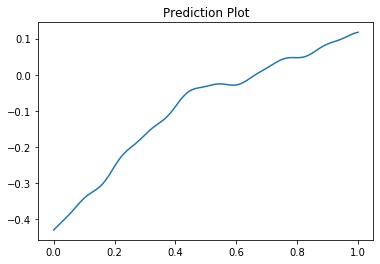

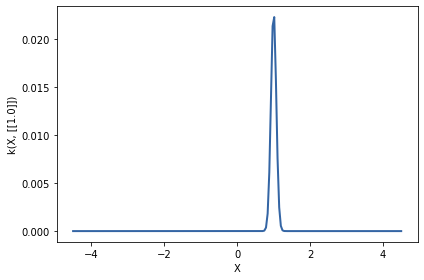

Decision is 1 for Id 62
Iteration: 120 of 120


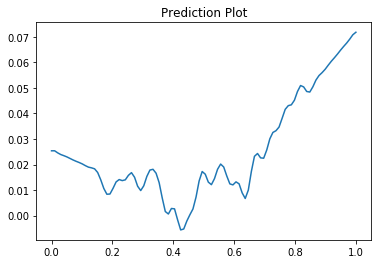

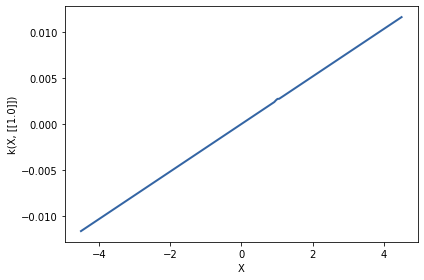

Decision is 0 for Id 63
Iteration: 120 of 120


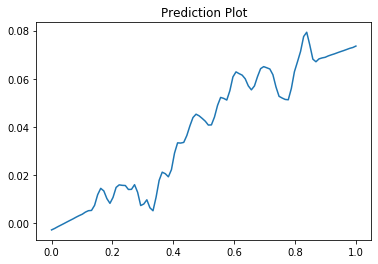

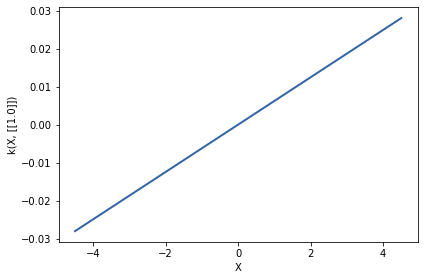

Decision is 0 for Id 64
Iteration: 120 of 120


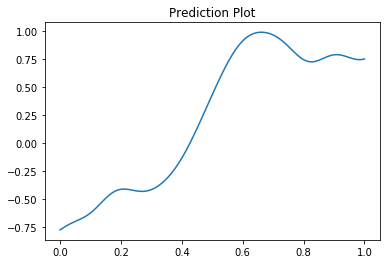

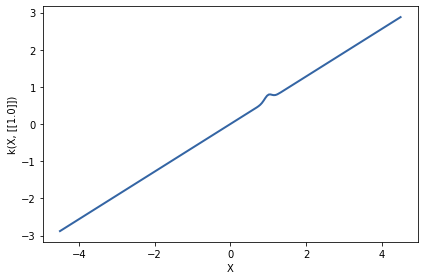

Decision is 0 for Id 65
Iteration: 120 of 120


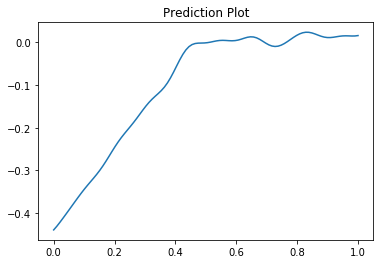

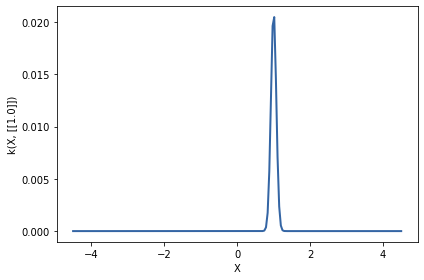

Decision is 0 for Id 66
Iteration: 120 of 120


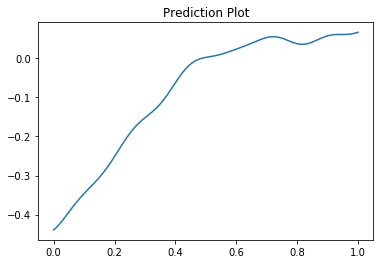

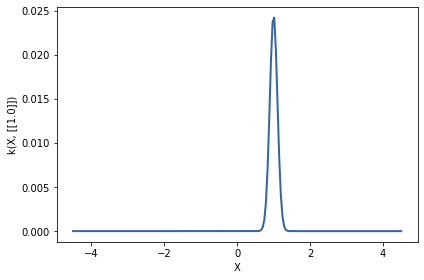

Decision is 1 for Id 67
Iteration: 120 of 120


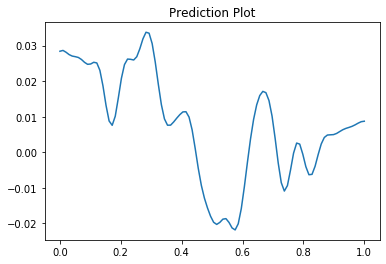

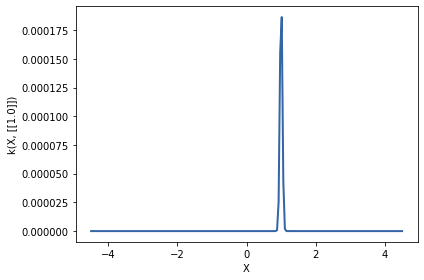

Decision is 0 for Id 68
Iteration: 120 of 120


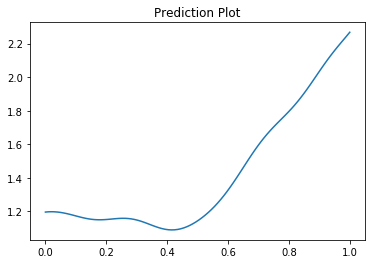

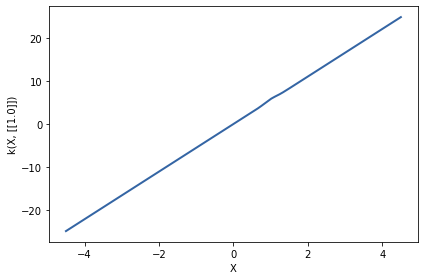

Decision is 0 for Id 69
Iteration: 120 of 120


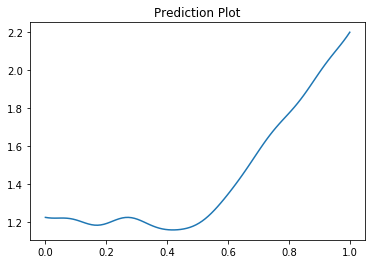

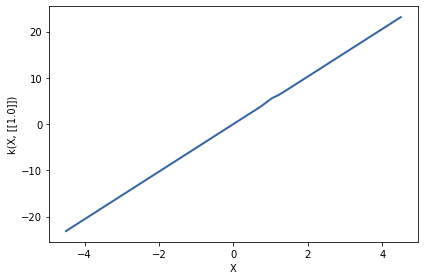

Decision is 0 for Id 70
Iteration: 120 of 120


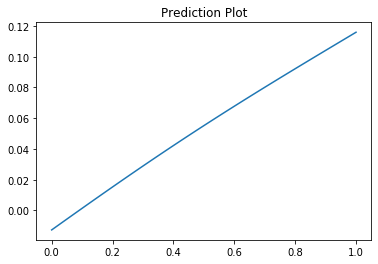

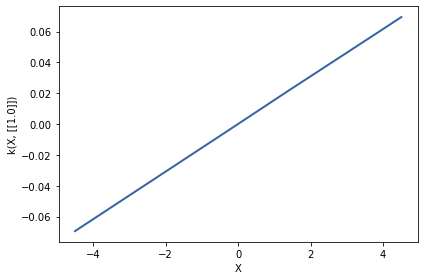

Decision is 1 for Id 71
Iteration: 120 of 120


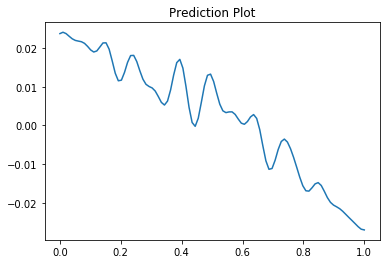

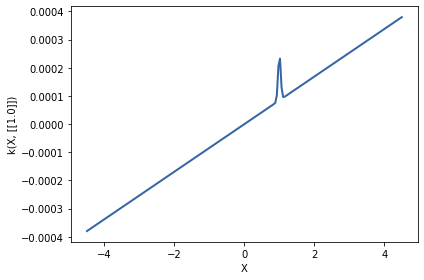

Decision is 0 for Id 72
Iteration: 120 of 120


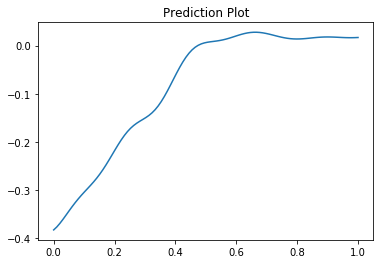

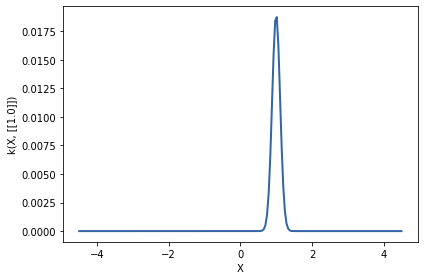

Decision is 0 for Id 73
Iteration: 120 of 120


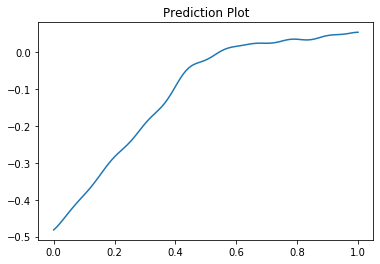

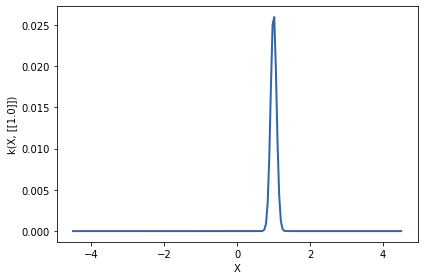

Decision is 1 for Id 74
Iteration: 120 of 120


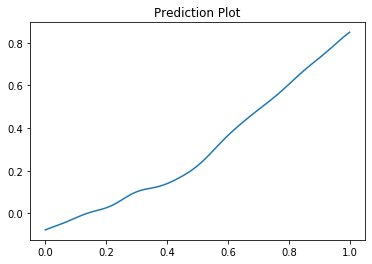

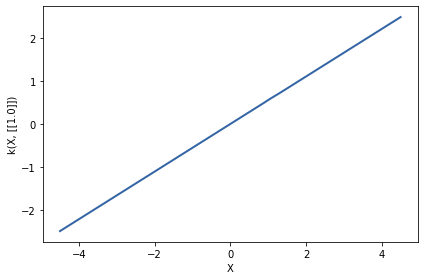

Decision is 1 for Id 75
Iteration: 120 of 120


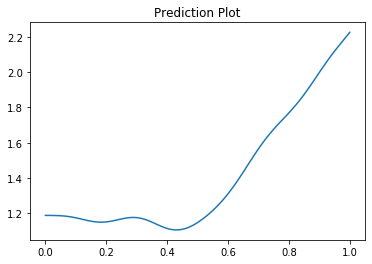

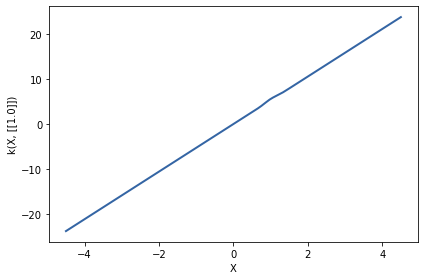

Decision is 0 for Id 76
Iteration: 120 of 120


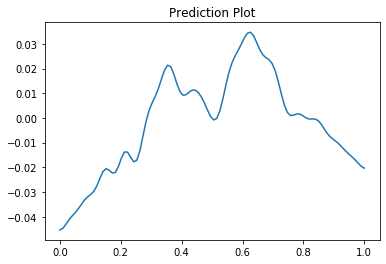

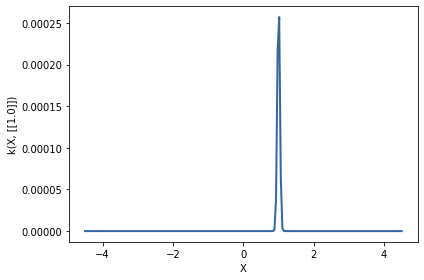

Decision is 0 for Id 77
Iteration: 120 of 120


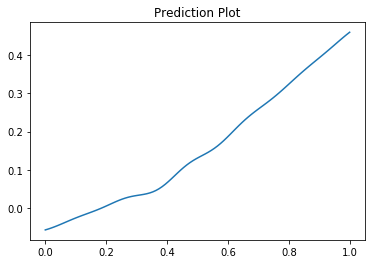

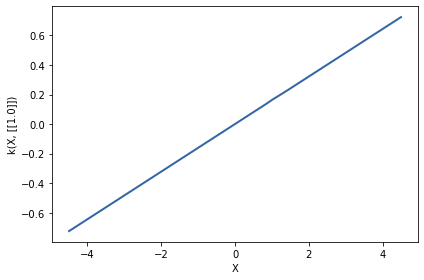

Decision is 1 for Id 78
Iteration: 120 of 120


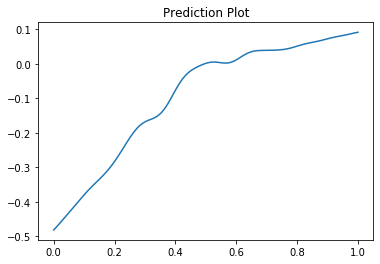

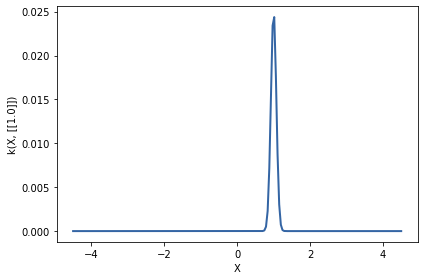

Decision is 1 for Id 79
Iteration: 120 of 120


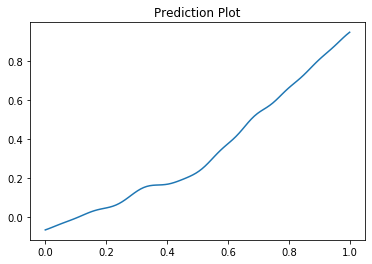

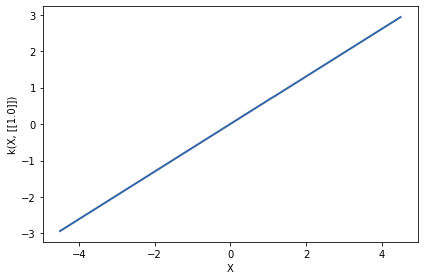

Decision is 1 for Id 80
Iteration: 120 of 120


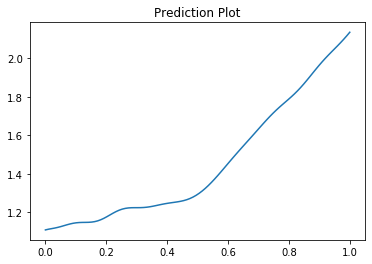

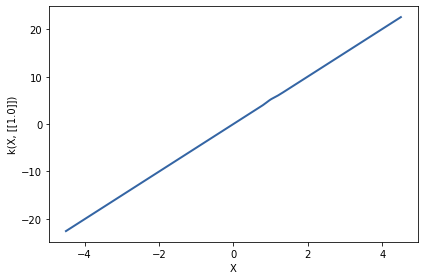

Decision is 1 for Id 81
Iteration: 120 of 120


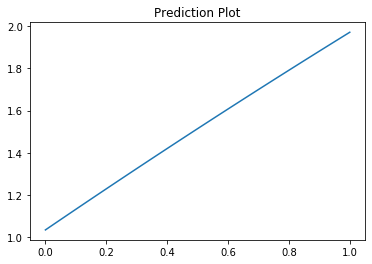

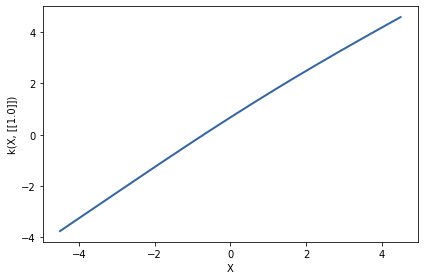

Decision is 1 for Id 82
Iteration: 120 of 120


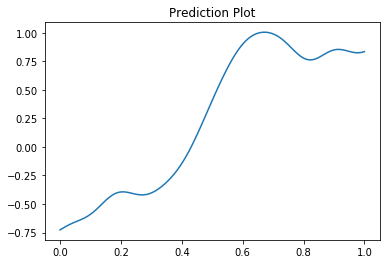

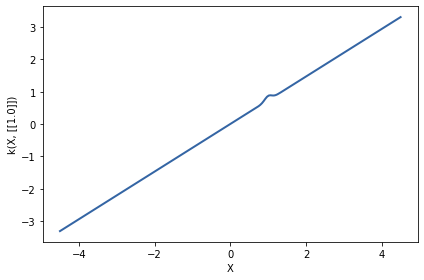

Decision is 0 for Id 83
Iteration: 120 of 120


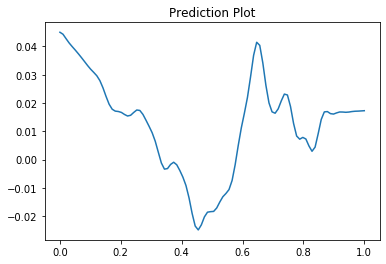

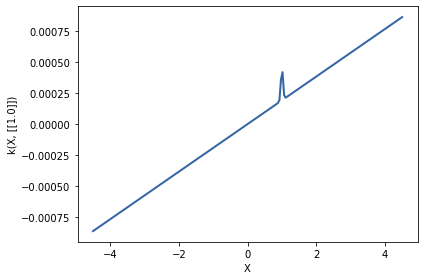

Decision is 0 for Id 84
Iteration: 120 of 120


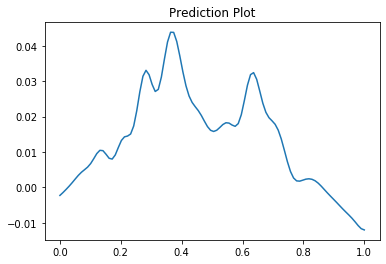

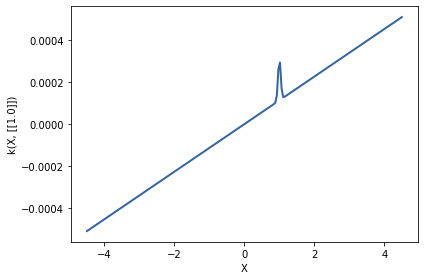

Decision is 0 for Id 85
Iteration: 120 of 120


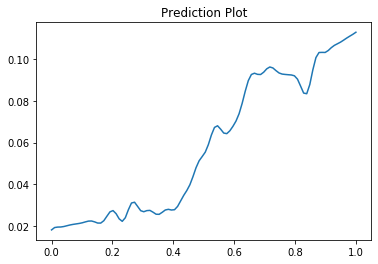

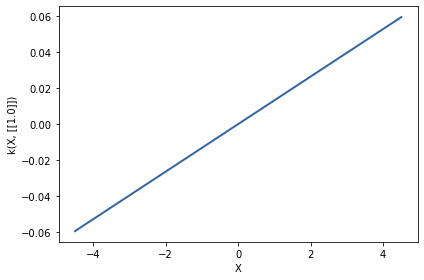

Decision is 0 for Id 86
Iteration: 120 of 120


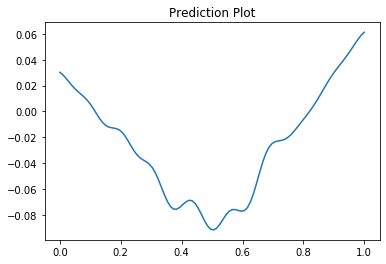

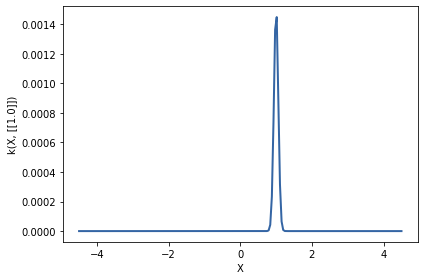

Decision is 0 for Id 87
Iteration: 120 of 120


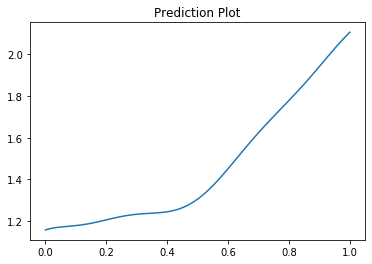

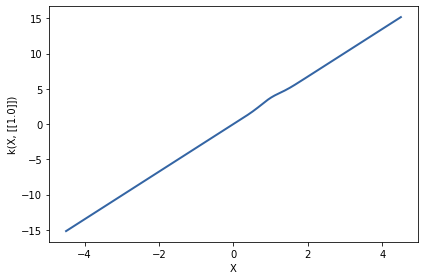

Decision is 1 for Id 88
Iteration: 120 of 120


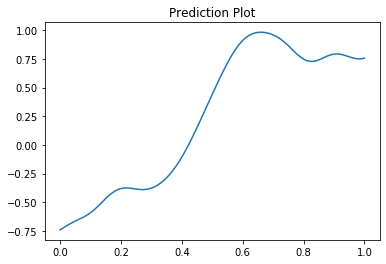

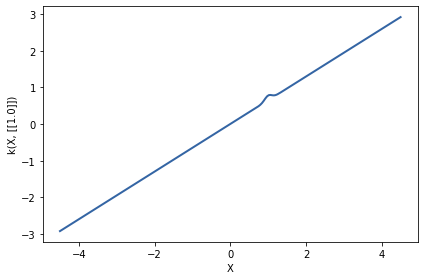

Decision is 0 for Id 89
Iteration: 120 of 120


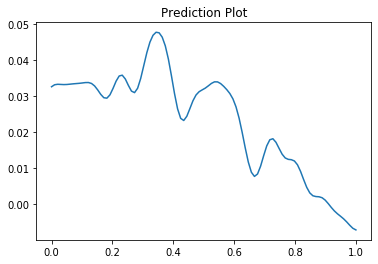

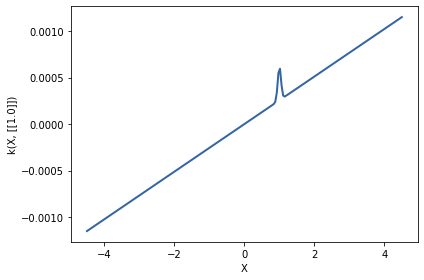

Decision is 0 for Id 90
Iteration: 120 of 120


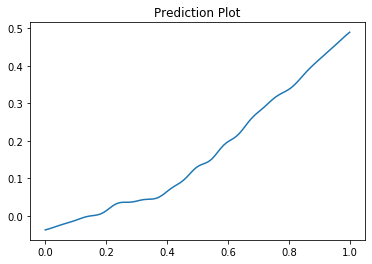

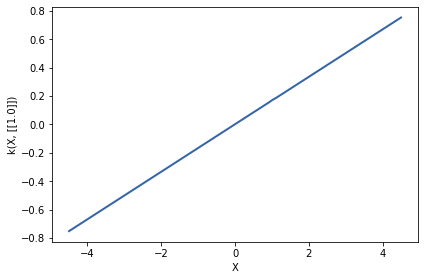

Decision is 1 for Id 91
Iteration: 120 of 120


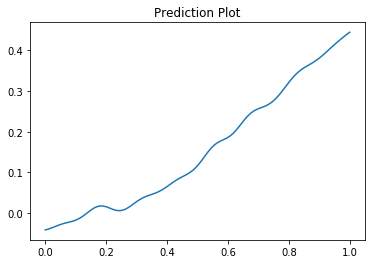

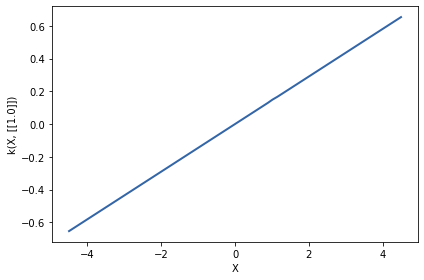

Decision is 1 for Id 92
Iteration: 120 of 120


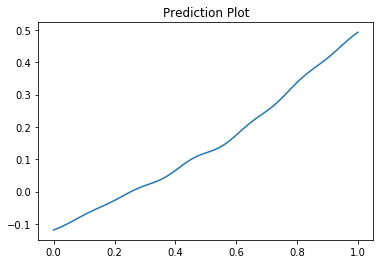

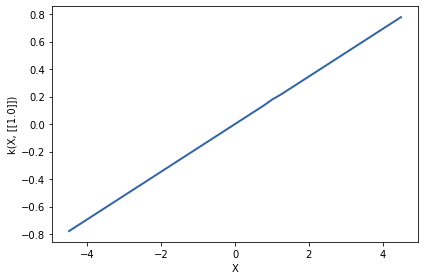

Decision is 1 for Id 93
Iteration: 120 of 120


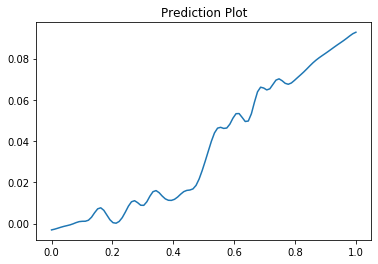

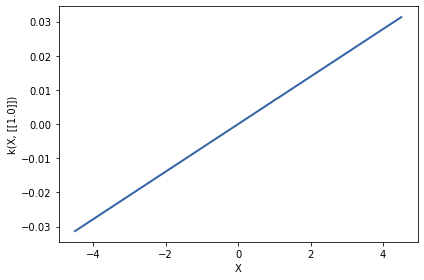

Decision is 0 for Id 94
Iteration: 120 of 120


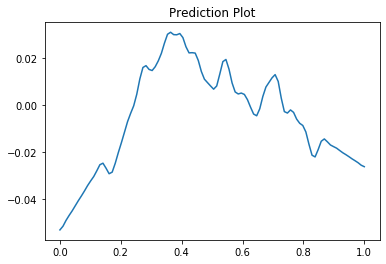

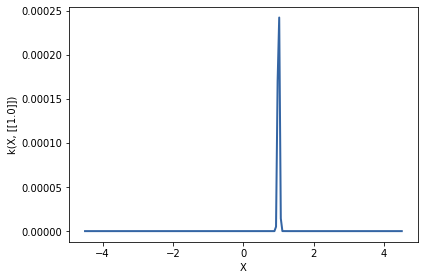

Decision is 0 for Id 95
Iteration: 120 of 120


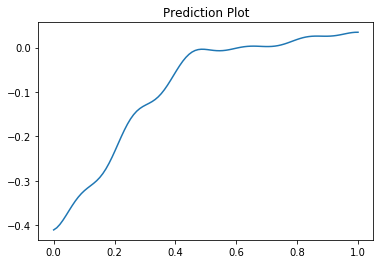

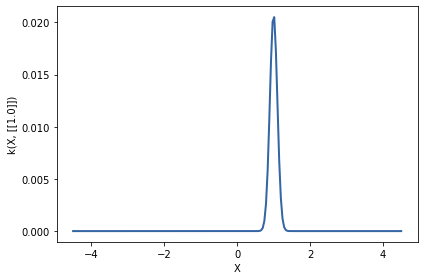

Decision is 1 for Id 96
Iteration: 120 of 120


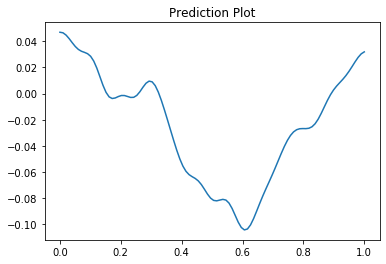

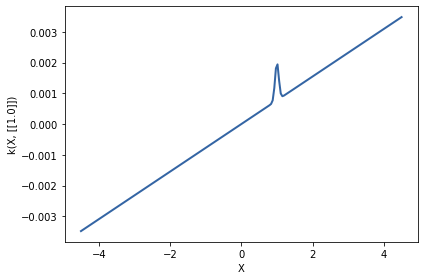

Decision is 0 for Id 97
Iteration: 120 of 120


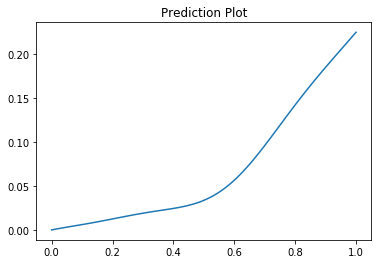

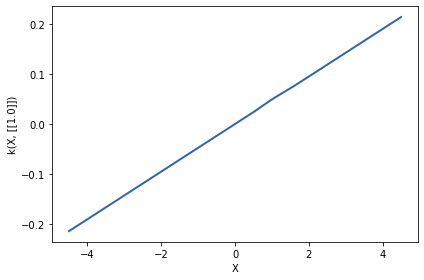

Decision is 1 for Id 98
Iteration: 120 of 120


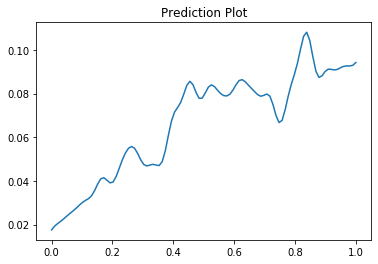

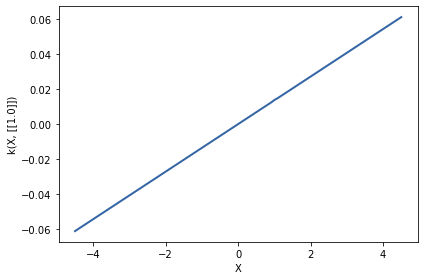

Decision is 0 for Id 99
Iteration: 120 of 120


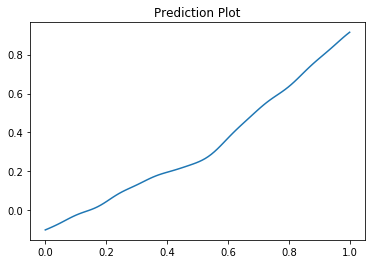

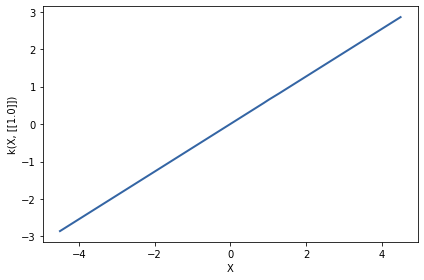

Decision is 1 for Id 100
Iteration: 120 of 120


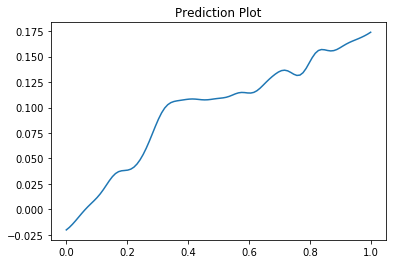

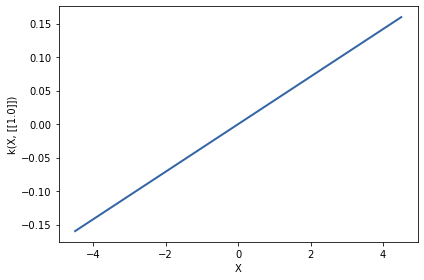

Decision is 0 for Id 101
Iteration: 120 of 120


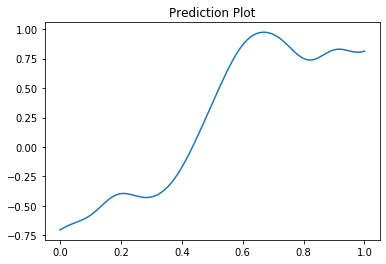

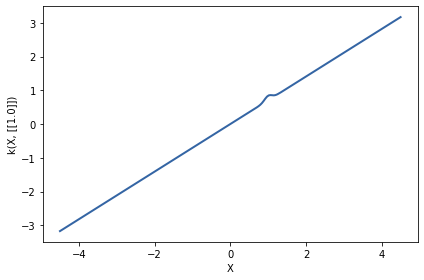

Decision is 0 for Id 102
Iteration: 120 of 120


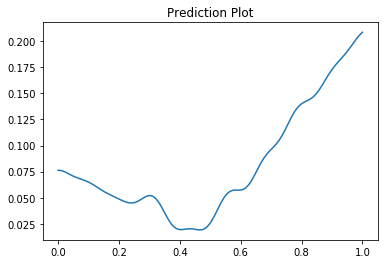

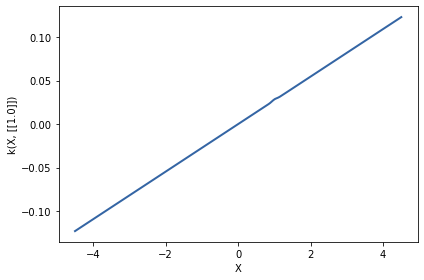

Decision is 0 for Id 103
Iteration: 120 of 120


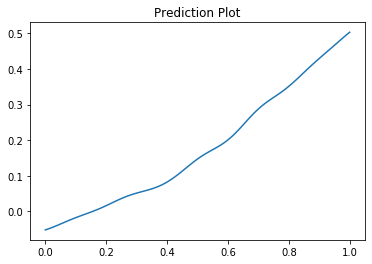

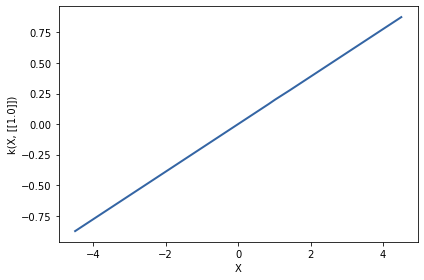

Decision is 1 for Id 104
Iteration: 120 of 120


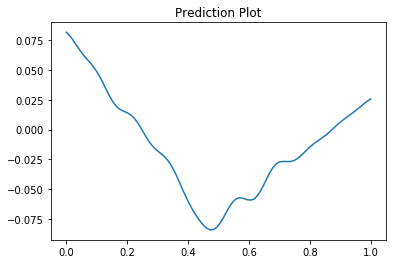

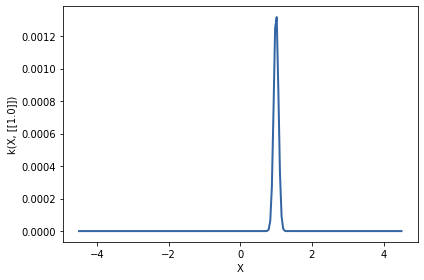

Decision is 0 for Id 105
Iteration: 120 of 120


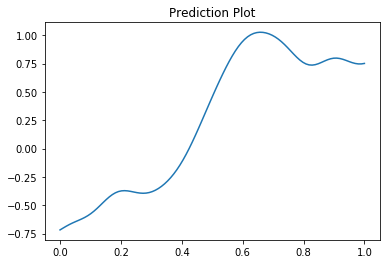

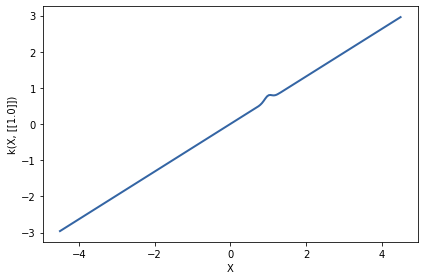

Decision is 0 for Id 106
Iteration: 120 of 120


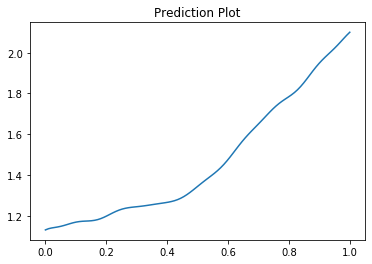

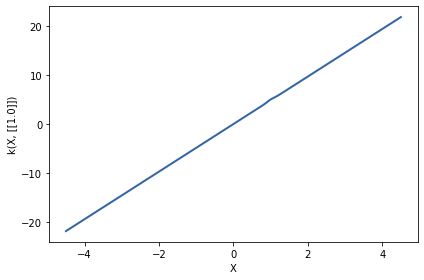

Decision is 1 for Id 107
Iteration: 120 of 120


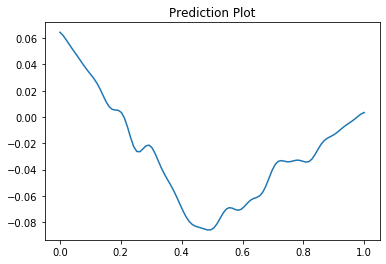

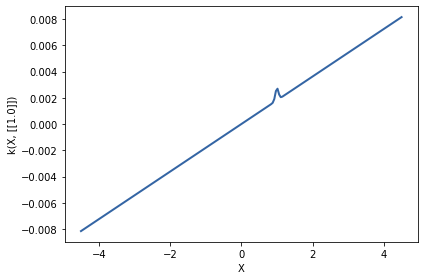

Decision is 0 for Id 108
Iteration: 120 of 120


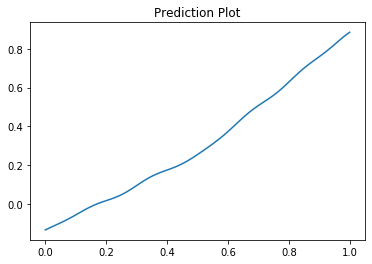

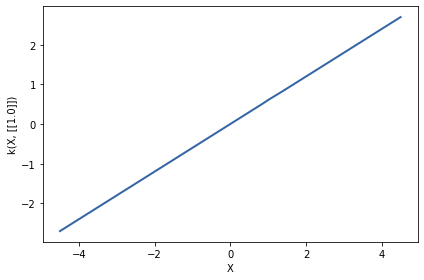

Decision is 1 for Id 109
Iteration: 120 of 120


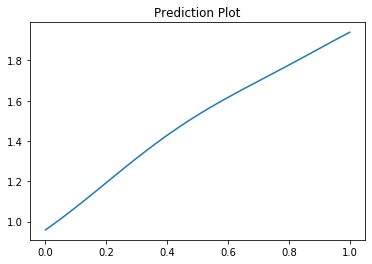

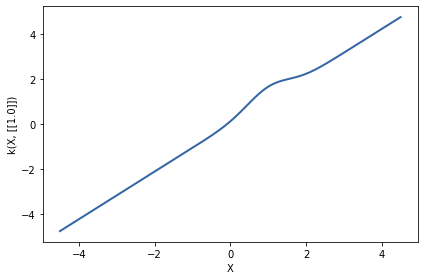

Decision is 1 for Id 110
Iteration: 120 of 120


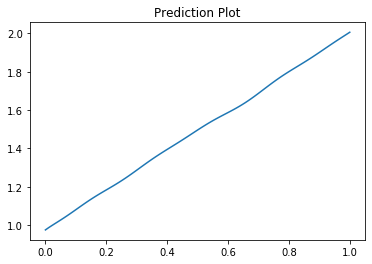

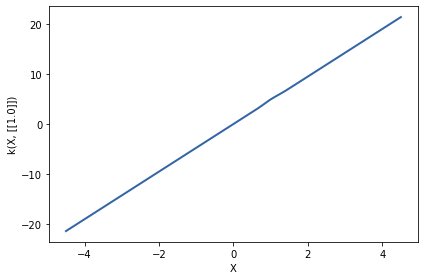

Decision is 1 for Id 111
Iteration: 120 of 120


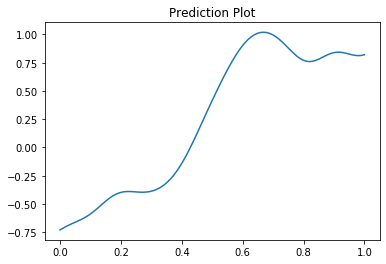

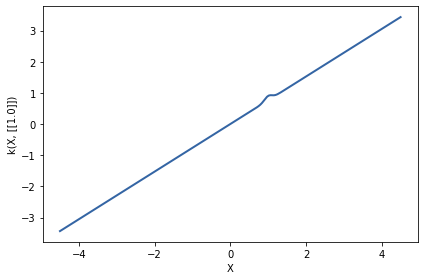

Decision is 0 for Id 112
Iteration: 120 of 120


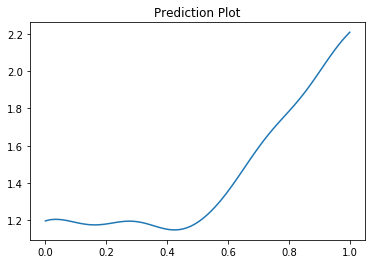

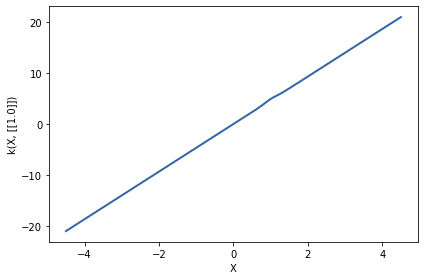

Decision is 0 for Id 113
Iteration: 120 of 120


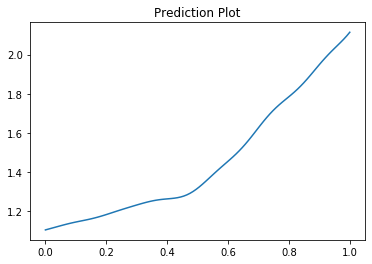

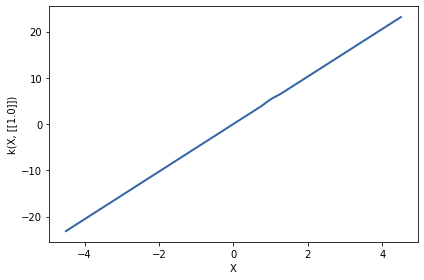

Decision is 1 for Id 114
Iteration: 120 of 120


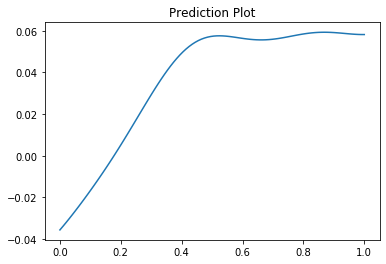

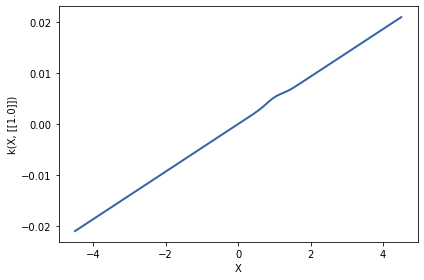

Decision is 0 for Id 115
Iteration: 120 of 120


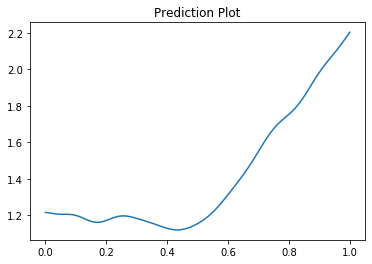

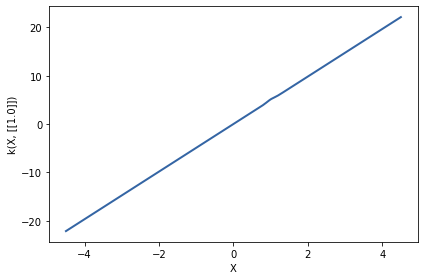

Decision is 0 for Id 116
Iteration: 120 of 120


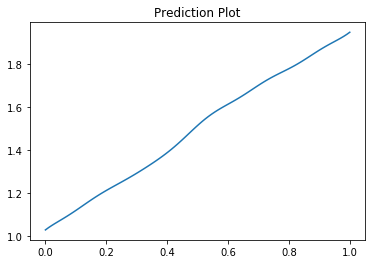

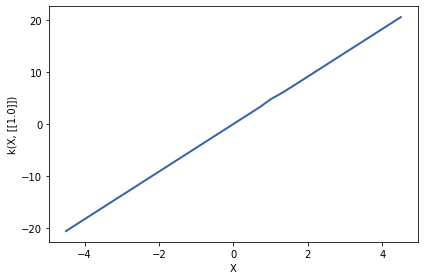

Decision is 1 for Id 117
Iteration: 120 of 120


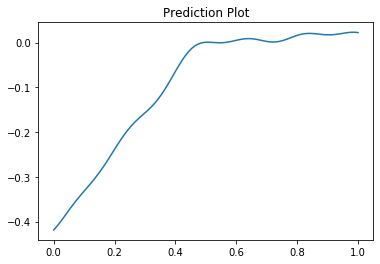

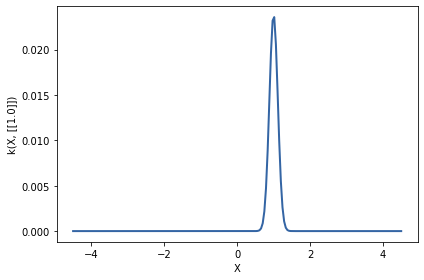

Decision is 0 for Id 118
Iteration: 120 of 120


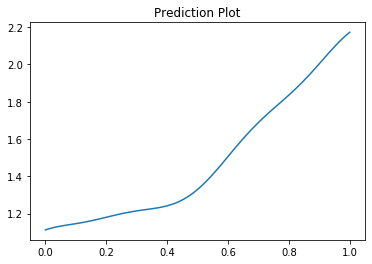

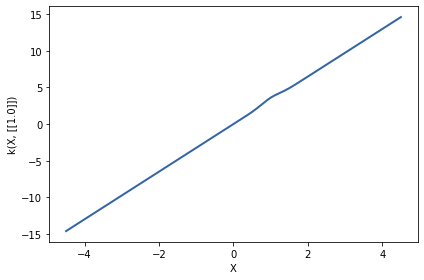

Decision is 1 for Id 119


In [400]:
test_df = pd.read_csv("./data/test.csv")
rows = test_df.shape[0]
x_d = np.linspace(0,1,100)[:, None]
Decision = pd.DataFrame(columns=['Id','Category'])
for r in range(rows):
    print(f'Iteration: {r+1} of {rows}')
    id_row = test_df.iloc[r,0]
    deco = seasonal_decompose(test_df.iloc[r,1:101].T, model='additive', freq=30, extrapolate_trend='freq')
    y_d = deco.trend.values[:, None]
    decision = run_model(x_d,y_d)
    print(f'Decision is {decision} for Id {id_row}')
    Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True) 
    
Decision.to_csv('submission.csv')